In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
from tqdm import tqdm

class DifferentialAttention(nn.Module):
    def __init__(self, dim, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.d_model = dim

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.lambda_q1 = nn.Parameter(torch.zeros(head_dim, dtype=torch.float32).normal_(mean=0, std=0.02))
        self.lambda_k1 = nn.Parameter(torch.zeros(head_dim, dtype=torch.float32).normal_(mean=0, std=0.02))
        self.lambda_q2 = nn.Parameter(torch.zeros(head_dim, dtype=torch.float32).normal_(mean=0, std=0.02))
        self.lambda_k2 = nn.Parameter(torch.zeros(head_dim, dtype=torch.float32).normal_(mean=0, std=0.02))
        self.lambda_init = 0.5  # You can experiment with different initializations

        self.attn_weights = None  # Add this line

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        # Split Q and K for differential attention
        q1, q2 = q.chunk(2, dim=-1)
        k1, k2 = k.chunk(2, dim=-1)

        # Original attention mechanism
        attn1 = (q1 @ k1.transpose(-2, -1)) * self.scale
        attn1 = attn1.softmax(dim=-1)
        attn1 = self.attn_drop(attn1)

        attn2 = (q2 @ k2.transpose(-2, -1)) * self.scale
        attn2 = attn2.softmax(dim=-1)
        attn2 = self.attn_drop(attn2)

        # Calculate lambda
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1)).unsqueeze(0).unsqueeze(0)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1)).unsqueeze(0).unsqueeze(0)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init
        lambda_full = lambda_full.to(attn1.device)  # Ensure lambda is on the same device

        # Differential attention
        attn = attn1 - lambda_full * attn2
        attn = attn.softmax(dim=-1) # Apply softmax after subtraction

        self.attn_weights = attn # Store attention weights

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        
        # Replace MultiHeadAttention with DifferentialAttention
        self.attn = DifferentialAttention(d_model, n_heads, qkv_bias=True, attn_drop=dropout, proj_drop=dropout)
        
        # Normalization layers
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        
        # MLP block
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * mlp_ratio),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * mlp_ratio, d_model),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # First sub-layer: Differential attention with residual connection
        residual = x
        x = self.ln1(x)  # Pre-norm architecture
        x = self.attn(x)
        
        # Get attention weights for visualization
        attentions = self.attn.attn_weights
        
        x = residual + x
        
        # Second sub-layer: MLP with residual connection
        residual = x
        x = self.ln2(x)  # Pre-norm architecture
        x = self.mlp(x)
        x = residual + x
        
        return x, attentions

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        
        # Create the [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Create sinusoidal positional encoding
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length).unsqueeze(1).float()
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register the positional encoding as a buffer (not a parameter)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Add CLS token to the sequence
        cls_tokens = self.cls_token.expand(batch_size, 1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add positional encoding
        x = x + self.pe[:, :x.size(1)]
        
        return x

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        
        # Create the [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Create learnable positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_length, d_model))
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Add CLS token to the sequence
        cls_tokens = self.cls_token.expand(batch_size, 1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add positional embedding
        x = x + self.pos_embedding[:, :x.size(1)]
        
        return x

class Learned2DPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length, grid_size):
        super().__init__()
        
        # Create the [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Grid size is (height, width) of the grid of patches
        h, w = grid_size
        
        # Create separate position embeddings for height and width
        self.pos_embedding_h = nn.Parameter(torch.randn(1, h, d_model // 2))
        self.pos_embedding_w = nn.Parameter(torch.randn(1, w, d_model // 2))
        
        # For CLS token
        self.cls_pos_embedding = nn.Parameter(torch.randn(1, 1, d_model))
        
    def forward(self, x):
        batch_size = x.size(0)
        seq_length = x.size(1)
        
        # Add CLS token to the sequence
        cls_tokens = self.cls_token.expand(batch_size, 1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # For the CLS token, use a special position embedding
        cls_pos = self.cls_pos_embedding.expand(batch_size, 1, -1)
        
        # For the patch tokens
        grid_h, grid_w = int(np.sqrt(seq_length)), int(np.sqrt(seq_length))
        
        # Reshape to 2D grid
        patch_tokens = x[:, 1:].view(batch_size, grid_h, grid_w, -1)
        
        # Get position embeddings for each spatial dimension
        pos_h = self.pos_embedding_h.expand(batch_size, -1, -1)
        pos_w = self.pos_embedding_w.expand(batch_size, -1, -1)
        
        # Combine position embeddings
        pos_h = pos_h.unsqueeze(2).expand(-1, -1, grid_w, -1)
        pos_w = pos_w.unsqueeze(1).expand(-1, grid_h, -1, -1)
        
        # Concatenate the h and w position embeddings
        patch_pos = torch.cat([pos_h, pos_w], dim=-1)
        
        # Add positional embeddings to patch tokens
        patch_tokens = patch_tokens + patch_pos
        
        # Flatten back to sequence
        patch_tokens = patch_tokens.view(batch_size, grid_h * grid_w, -1)
        
        # Combine with CLS token
        x = torch.cat([cls_tokens + cls_pos, patch_tokens], dim=1)
        
        return x

class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        
        self.d_model = d_model
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        
        # Number of patches
        self.n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        
        # Linear projection of patches
        self.projection = nn.Conv2d(
            n_channels, d_model, 
            kernel_size=patch_size, 
            stride=patch_size
        )
        
        # Layer normalization
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        # Project patches: (batch_size, n_channels, height, width) -> (batch_size, d_model, h', w')
        x = self.projection(x)
        
        # Flatten patches: (batch_size, d_model, h', w') -> (batch_size, d_model, n_patches)
        x = x.flatten(2)
        
        # Transpose: (batch_size, d_model, n_patches) -> (batch_size, n_patches, d_model)
        x = x.transpose(1, 2)
        
        # Apply normalization
        x = self.norm(x)
        
        return x

class VisionTransformer(nn.Module):
    def __init__(
        self, 
        d_model, 
        n_classes, 
        img_size, 
        patch_size, 
        n_channels, 
        n_heads, 
        n_layers,
        mlp_ratio=4,
        dropout=0.1,
        pos_embedding_type='1d_learned'
    ):
        super().__init__()
        
        # Validate input dimensions
        assert img_size[0] % patch_size[0] == 0, "Image height must be divisible by patch height"
        assert img_size[1] % patch_size[1] == 0, "Image width must be divisible by patch width"
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        # Store parameters
        self.d_model = d_model
        self.n_classes = n_classes
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_heads = n_heads
        self.n_layers = n_layers
        
        # Calculate number of patches
        self.n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        self.max_seq_length = self.n_patches + 1  # +1 for CLS token
        
        # Patch embedding layer
        self.patch_embedding = PatchEmbedding(d_model, img_size, patch_size, n_channels)
        
        # Positional embedding
        grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        
        if pos_embedding_type == 'none':
            # Just add CLS token without positional embedding
            self.positional_encoding = nn.Module()
            self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
            
            def forward_none(x):
                batch_size = x.size(0)
                cls_tokens = self.cls_token.expand(batch_size, 1, -1)
                return torch.cat((cls_tokens, x), dim=1)
                
            self.positional_encoding.forward = forward_none
        elif pos_embedding_type == '1d_learned':
            self.positional_encoding = LearnedPositionalEncoding(d_model, self.max_seq_length)
        elif pos_embedding_type == '2d_learned':
            self.positional_encoding = Learned2DPositionalEncoding(d_model, self.max_seq_length, grid_size)
        elif pos_embedding_type == 'sinusoidal':
            self.positional_encoding = SinusoidalPositionalEncoding(d_model, self.max_seq_length)
        else:
            raise ValueError(f"Unknown positional embedding type: {pos_embedding_type}")
        
        # Input dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        self.transformer_layers = nn.ModuleList([
            TransformerEncoder(d_model, n_heads, mlp_ratio, dropout)
            for _ in range(n_layers)
        ])
        
        # Final layer normalization
        self.ln_f = nn.LayerNorm(d_model)
        
        # Classification head
        self.classifier = nn.Linear(d_model, n_classes)
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)
            
    def forward(self, x):
        # Embed patches: (batch_size, n_channels, height, width) -> (batch_size, n_patches, d_model)
        x = self.patch_embedding(x)
        
        # Add positional embeddings
        x = self.positional_encoding(x)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Store attention weights for visualization
        all_attentions = []
        
        # Apply transformer layers
        for layer in self.transformer_layers:
            x, attentions = layer(x)
            all_attentions.append(attentions)
        
        # Apply final layer norm
        x = self.ln_f(x)
        
        # Use CLS token for classification
        x = x[:, 0]
        
        # Apply classification head
        logits = self.classifier(x)
        
        return logits, all_attentions

def get_cifar10_dataloaders(batch_size=64, augmentation=None):
    # Default transforms
    if augmentation is None:
        transform_train = T.Compose([
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
    else:
        transform_train = augmentation
        
    transform_test = T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    # Load datasets
    train_set = CIFAR10(root="./data", train=True, download=True, transform=transform_train)
    test_set = CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    
    # Create data loaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, test_loader

def train(model, train_loader, optimizer, criterion, device, scheduler=None):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update learning rate if scheduler is provided
        if scheduler is not None:
            scheduler.step()
        
        # Calculate statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': total_loss / (progress_bar.n + 1),
            'acc': 100 * correct / total
        })
    
    avg_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    return avg_loss, train_acc

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            
            # Calculate statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, epochs, scheduler=None):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    best_accuracy = 0.0
    best_model_path = "best_vit_model.pth"
    
    for epoch in range(epochs):
        # Train model
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device, scheduler)
        
        # Evaluate model
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
        
        # Save model if test accuracy improves
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saving Best Model at Epoch {epoch+1} with Accuracy: {best_accuracy:.2f}%")
    
    print(f"\nBest Test Accuracy: {best_accuracy:.2f}% — Model saved to: {best_model_path}")
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'best_accuracy': best_accuracy
    }

def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_losses']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot training and test loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_losses'], 'b-', label='Training Loss')
    plt.plot(epochs, metrics['test_losses'], 'r-', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot training and test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_accs'], 'b-', label='Training Accuracy')
    plt.plot(epochs, metrics['test_accs'], 'r-', label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('vit_metrics.png')
    plt.show()

def visualize_attention(model, dataloader, device, num_examples=4):
    model.eval()
    
    # Get a batch of images
    images, labels = next(iter(dataloader))
    images = images[:num_examples].to(device)
    labels = labels[:num_examples]
    
    # Get outputs and attention weights
    with torch.no_grad():
        outputs, all_attentions = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Create a figure
    fig, axes = plt.subplots(num_examples, model.n_layers + 1, figsize=(3 * (model.n_layers + 1), 3 * num_examples))
    
    # Get class names
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    # Plot images and attention maps
    for i in range(num_examples):
        # Plot original image
        if num_examples == 1:
            ax = axes[0]
        else:
            ax = axes[i, 0]
            
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img * np.array([0.2470, 0.2435, 0.2616])) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}")
        ax.axis('off')
        
        # Plot attention maps for each layer
        for j, layer_attentions in enumerate(all_attentions):
            # Get attention weights from the first head for visualization
            # For CLS token attention to all tokens
            attn_map = layer_attentions[0][i, 0, 0, 1:].reshape((int(np.sqrt(model.n_patches)), int(np.sqrt(model.n_patches))))
            
            if num_examples == 1:
                ax = axes[j + 1]
            else:
                ax = axes[i, j + 1]
                
            ax.imshow(attn_map.cpu().numpy(), cmap='viridis')
            ax.set_title(f"Layer {j+1}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('attention_visualization.png')
    plt.show()

def attention_rollout(attention_maps):
    """
    Compute attention rollout according to the ViT paper.
    
    Args:
        attention_maps: List of attention tensors for each layer of shape (batch_size, num_heads, seq_len, seq_len)
        
    Returns:
        Rolled-out attention map of shape (batch_size, seq_len, seq_len)
    """
    num_layers = len(attention_maps)
    batch_size, num_heads, seq_len, _ = attention_maps[0].shape
    
    # Average attention maps across heads for each layer
    attention_maps = [attn.mean(dim=1) for attn in attention_maps]
    
    # Start with identity matrix
    eye = torch.eye(seq_len).unsqueeze(0).expand(batch_size, -1, -1).to(attention_maps[0].device)
    rollout = eye
    
    # Recursively multiply attention matrices
    for attn_map in attention_maps:
        rollout = torch.bmm(attn_map, rollout)
    
    return rollout

def visualize_attention_rollout(model, dataloader, device, num_examples=4):
    model.eval()
    
    # Get a batch of images
    images, labels = next(iter(dataloader))
    images = images[:num_examples].to(device)
    labels = labels[:num_examples]
    
    # Get outputs and attention weights
    with torch.no_grad():
        outputs, all_attentions = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Process attention maps for rollout
    attention_maps = []
    for layer_idx in range(len(all_attentions)):
        # Reshape attention tensors: list of tuples of attention maps -> tensor of shape (batch, heads, seq_len, seq_len)
        attn_tensors = []
        for head_idx in range(model.n_heads):
            attn_tensors.append(torch.stack([attn[head_idx] for attn in all_attentions[layer_idx]], dim=0))
        attention_maps.append(torch.stack(attn_tensors, dim=1))
    
    # Compute attention rollout
    rollout_maps = attention_rollout(attention_maps)
    
    # Get class names
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    # Create a figure
    fig, axes = plt.subplots(num_examples, 3, figsize=(12, 4 * num_examples))
    
    # Plot images and attention rollout maps
    for i in range(num_examples):
        # Plot original image
        if num_examples == 1:
            ax = axes[0]
        else:
            ax = axes[i, 0]
            
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img * np.array([0.2470, 0.2435, 0.2616])) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}")
        ax.axis('off')
        
        # Plot attention rollout map for CLS token
        if num_examples == 1:
            ax = axes[1]
        else:
            ax = axes[i, 1]
            
        # Extract CLS token attention to all tokens
        cls_attn = rollout_maps[i, 0, 1:].reshape(int(np.sqrt(model.n_patches)), int(np.sqrt(model.n_patches)))
        
        ax.imshow(cls_attn.cpu().numpy(), cmap='viridis')
        ax.set_title("CLS Token Attention Rollout")
        ax.axis('off')
        
        # Overlay attention map on original image
        if num_examples == 1:
            ax = axes[2]
        else:
            ax = axes[i, 2]
            
        ax.imshow(img)
        
        # Resize attention map to image size
        h, w = img.shape[:2]
        attn_h, attn_w = cls_attn.shape
        
        # Upsample attention map to image size
        cls_attn_resized = F.interpolate(
            cls_attn.unsqueeze(0).unsqueeze(0),
            size=(h, w),
            mode='bilinear'
        ).squeeze().cpu().numpy()
        
        ax.imshow(cls_attn_resized, cmap='viridis', alpha=0.6)
        ax.set_title("Attention Overlay")
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('attention_rollout.png')
    plt.show()

def visualize_positional_embeddings(model):
    """Visualize the similarities between positional embeddings"""
    if hasattr(model.positional_encoding, 'pos_embedding'):
        # Get positional embeddings (excluding CLS token)
        pos_embed = model.positional_encoding.pos_embedding.squeeze(0)[1:]
        
        # Compute similarity matrix
        sim = pos_embed @ pos_embed.transpose

def visualize_positional_embeddings(model):
    """Visualize the similarities between positional embeddings"""
    if hasattr(model.positional_encoding, 'pos_embedding'):
        # Get positional embeddings (excluding CLS token)
        pos_embed = model.positional_encoding.pos_embedding.squeeze(0)[1:]
        
        # Compute similarity matrix
        sim = pos_embed @ pos_embed.transpose(0, 1)
        
        # Create a figure
        plt.figure(figsize=(8, 8))
        plt.imshow(sim.detach().cpu().numpy(), cmap='viridis')
        plt.colorbar()
        plt.title('Positional Embedding Similarities')
        plt.xlabel('Position')
        plt.ylabel('Position')
        plt.savefig('pos_embedding_similarities.png')
        plt.show()
    else:
        print("Model does not have learnable positional embeddings")

# Configurations for experiments

def get_default_config():
    """Get default configuration for ViT model"""
    return {
        'd_model': 384,         # Embedding dimension
        'n_classes': 10,        # Number of classes (CIFAR-10)
        'img_size': (32, 32),   # Image size
        'patch_size': (4, 4),   # Patch size
        'n_channels': 3,        # Number of image channels
        'n_heads': 6,           # Number of attention heads
        'n_layers': 8,          # Number of transformer layers
        'mlp_ratio': 4,         # MLP hidden size ratio
        'dropout': 0.1,         # Dropout rate
        'batch_size': 128,      # Batch size
        'epochs': 50,           # Number of training epochs
        'lr': 3e-4,             # Learning rate
        'weight_decay': 0.05,   # Weight decay
        'warmup_steps': 500,    # Learning rate warmup steps
        'pos_embedding_type': '1d_learned'  # Positional embedding type
    }

def get_data_augmentation():
    """Get data augmentation transforms for CIFAR-10"""
    return T.Compose([
        T.RandomResizedCrop(32, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.RandAugment(num_ops=2, magnitude=9),
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

def run_experiment(config, data_augmentation=None, exp_name="default"):
    """Run a ViT experiment with the given configuration"""
    print(f"\n=== Running experiment: {exp_name} ===")
    print("Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")
    
    # Get data loaders
    train_loader, test_loader = get_cifar10_dataloaders(config['batch_size'], data_augmentation)
    print(f"Train samples: {len(train_loader.dataset)}, Test samples: {len(test_loader.dataset)}")
    
    # Create model
    model = VisionTransformer(
        d_model=config['d_model'],
        n_classes=config['n_classes'],
        img_size=config['img_size'],
        patch_size=config['patch_size'],
        n_channels=config['n_channels'],
        n_heads=config['n_heads'],
        n_layers=config['n_layers'],
        mlp_ratio=config['mlp_ratio'],
        dropout=config['dropout'],
        pos_embedding_type=config['pos_embedding_type']
    ).to(device)
    
    # Print model summary
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {num_params / 1e6:.2f}M")
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )
    
    # Create learning rate scheduler
    total_steps = len(train_loader) * config['epochs']
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)
    
    # Train and evaluate model
    metrics = train_and_evaluate(
        model, train_loader, test_loader, optimizer, criterion, device, config['epochs'], scheduler
    )
    
    # Plot metrics
    plot_metrics(metrics)
    
    # Visualization
    if exp_name == "best":
        # Load best model for visualization
        model.load_state_dict(torch.load("best_vit_model.pth"))
        
        # Visualize attention maps
        visualize_attention(model, test_loader, device)
        
        # Visualize attention rollout
        visualize_attention_rollout(model, test_loader, device)
        
        # Visualize positional embeddings
        if config['pos_embedding_type'] == '1d_learned':
            visualize_positional_embeddings(model)
    
    return metrics, model

def patch_size_experiment():
    """Experiment with different patch sizes"""
    results = {}
    
    # Base configuration
    base_config = get_default_config()
    
    # Patch sizes to test
    patch_sizes = [(2, 2), (4, 4), (8, 8)]
    
    for patch_size in patch_sizes:
        # Update configuration
        config = base_config.copy()
        config['patch_size'] = patch_size
        
        # Adjust model size based on patch size to keep computation similar
        if patch_size == (2, 2):
            config['d_model'] = 256
            config['n_heads'] = 4
        elif patch_size == (8, 8):
            config['d_model'] = 512
            config['n_heads'] = 8
        
        # Run experiment
        exp_name = f"patch_size_{patch_size[0]}x{patch_size[1]}"
        metrics, _ = run_experiment(config, exp_name=exp_name)
        
        # Store results
        results[exp_name] = metrics
    
    return results

def hyperparameter_experiment():
    """Experiment with different hyperparameters"""
    results = {}
    
    # Base configuration
    base_config = get_default_config()
    
    # Hyperparameter combinations to test
    configs = [
        # Basic configuration
        base_config.copy(),
        
        # Deeper model
        {**base_config, 'n_layers': 12, 'lr': 2e-4},
        
        # Wider model
        {**base_config, 'd_model': 512, 'n_heads': 8, 'lr': 2e-4},
        
        # Higher MLP ratio
        {**base_config, 'mlp_ratio': 6},
        
        # More heads
        {**base_config, 'n_heads': 12, 'd_model': 384},
    ]
    
    for i, config in enumerate(configs):
        # Run experiment
        exp_name = f"hyperparams_{i+1}"
        metrics, _ = run_experiment(config, exp_name=exp_name)
        
        # Store results
        results[exp_name] = metrics
    
    return results

def augmentation_experiment():
    """Experiment with different data augmentation techniques"""
    results = {}
    
    # Base configuration
    config = get_default_config()
    
    # No augmentation (baseline)
    metrics_baseline, _ = run_experiment(config, exp_name="no_augmentation")
    results["no_augmentation"] = metrics_baseline
    
    # Basic augmentation
    basic_augmentation = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomCrop(32, padding=4),
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    metrics_basic, _ = run_experiment(config, basic_augmentation, exp_name="basic_augmentation")
    results["basic_augmentation"] = metrics_basic
    
    # Advanced augmentation
    advanced_augmentation = T.Compose([
        T.RandomResizedCrop(32, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    metrics_advanced, _ = run_experiment(config, advanced_augmentation, exp_name="advanced_augmentation")
    results["advanced_augmentation"] = metrics_advanced
    
    # RandAugment
    try:
        randaugment = get_data_augmentation()
        metrics_randaug, _ = run_experiment(config, randaugment, exp_name="randaugment")
        results["randaugment"] = metrics_randaug
    except:
        print("RandAugment not available, skipping this experiment")
    
    return results

def positional_embedding_experiment():
    """Experiment with different positional embedding types"""
    results = {}
    
    # Base configuration
    base_config = get_default_config()
    
    # Position embedding types to test
    pos_types = ['none', '1d_learned', '2d_learned', 'sinusoidal']
    
    for pos_type in pos_types:
        # Update configuration
        config = base_config.copy()
        config['pos_embedding_type'] = pos_type
        
        # Run experiment
        metrics, _ = run_experiment(config, exp_name=f"pos_embed_{pos_type}")
        
        # Store results
        results[pos_type] = metrics
    
    return results

def best_model_experiment():
    """Train the best model configuration"""
    # Best configuration based on previous experiments
    best_config = {
        'd_model': 512,         # Larger embedding dimension
        'n_classes': 10,        # CIFAR-10
        'img_size': (32, 32),   # CIFAR-10 image size
        'patch_size': (4, 4),   # Medium patch size 
        'n_channels': 3,        # RGB
        'n_heads': 8,           # More attention heads
        'n_layers': 12,         # Deeper model
        'mlp_ratio': 4,         # Standard MLP ratio
        'dropout': 0.1,         # Dropout for regularization
        'batch_size': 128,      # Reasonable batch size
        'epochs': 100,          # More training epochs
        'lr': 3e-4,             # Learning rate
        'weight_decay': 0.05,   # Weight decay for regularization
        'warmup_steps': 1000,   # More warmup steps
        'pos_embedding_type': '1d_learned'  # Best performing positional embedding
    }
    
    # Use strong data augmentation
    augmentation = get_data_augmentation()
    
    # Run experiment
    metrics, model = run_experiment(best_config, augmentation, exp_name="best")
    
    return metrics, model


=== Running experiment: patch_size_2x2 ===
Configuration:
  d_model: 256
  n_classes: 10
  img_size: (32, 32)
  patch_size: (2, 2)
  n_channels: 3
  n_heads: 4
  n_layers: 8
  mlp_ratio: 4
  dropout: 0.1
  batch_size: 128
  epochs: 50
  lr: 0.0003
  weight_decay: 0.05
  warmup_steps: 500
  pos_embedding_type: 1d_learned

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000, Test samples: 10000
Model parameters: 6.39M


Epoch 1/50 | Train Loss: 2.0030 | Train Acc: 25.07% | Test Loss: 1.7740 | Test Acc: 33.84%
Saving Best Model at Epoch 1 with Accuracy: 33.84%


Epoch 2/50 | Train Loss: 1.7028 | Train Acc: 36.00% | Test Loss: 1.5497 | Test Acc: 41.84%
Saving Best Model at Epoch 2 with Accuracy: 41.84%


Epoch 3/50 | Train Loss: 1.4767 | Train Acc: 44.90% | Test Loss: 1.3699 | Test Acc: 50.09%
Saving Best Model at Epoch 3 with Accuracy: 50.09%


Epoch 4/50 | Train Loss: 1.3202 | Train Acc: 51.62% | Test Loss: 1.3599 | Test Acc: 51.58%
Saving Best Model at Epoch 4 with Accuracy: 51.58%


Epoch 5/50 | Train Loss: 1.2118 | Train Acc: 55.43% | Test Loss: 1.4540 | Test Acc: 51.77%
Saving Best Model at Epoch 5 with Accuracy: 51.77%


Epoch 6/50 | Train Loss: 1.1278 | Train Acc: 58.97% | Test Loss: 1.2859 | Test Acc: 55.90%
Saving Best Model at Epoch 6 with Accuracy: 55.90%


Epoch 7/50 | Train Loss: 1.0549 | Train Acc: 61.78% | Test Loss: 1.2489 | Test Acc: 57.94%
Saving Best Model at Epoch 7 with Accuracy: 57.94%


Epoch 8/50 | Train Loss: 1.0077 | Train Acc: 63.59% | Test Loss: 1.6027 | Test Acc: 52.09%


Epoch 9/50 | Train Loss: 0.9573 | Train Acc: 65.49% | Test Loss: 1.2937 | Test Acc: 58.51%
Saving Best Model at Epoch 9 with Accuracy: 58.51%


Epoch 10/50 | Train Loss: 0.9187 | Train Acc: 66.96% | Test Loss: 1.2968 | Test Acc: 59.22%
Saving Best Model at Epoch 10 with Accuracy: 59.22%


Epoch 11/50 | Train Loss: 0.8852 | Train Acc: 68.23% | Test Loss: 1.3393 | Test Acc: 58.11%


Epoch 12/50 | Train Loss: 0.8464 | Train Acc: 69.62% | Test Loss: 1.1817 | Test Acc: 61.55%
Saving Best Model at Epoch 12 with Accuracy: 61.55%


Epoch 13/50 | Train Loss: 0.8195 | Train Acc: 70.67% | Test Loss: 1.2796 | Test Acc: 59.90%


Epoch 14/50 | Train Loss: 0.7871 | Train Acc: 71.72% | Test Loss: 1.3479 | Test Acc: 58.72%


Epoch 15/50 | Train Loss: 0.7615 | Train Acc: 72.60% | Test Loss: 1.3739 | Test Acc: 59.65%


Epoch 16/50 | Train Loss: 0.7371 | Train Acc: 73.49% | Test Loss: 1.2651 | Test Acc: 61.04%


Epoch 17/50 | Train Loss: 0.7170 | Train Acc: 74.52% | Test Loss: 1.1388 | Test Acc: 63.71%
Saving Best Model at Epoch 17 with Accuracy: 63.71%


Epoch 18/50 | Train Loss: 0.6932 | Train Acc: 75.26% | Test Loss: 1.1729 | Test Acc: 63.61%


Epoch 19/50 | Train Loss: 0.6642 | Train Acc: 76.16% | Test Loss: 1.2299 | Test Acc: 64.07%
Saving Best Model at Epoch 19 with Accuracy: 64.07%


Epoch 20/50 | Train Loss: 0.6381 | Train Acc: 77.12% | Test Loss: 1.1960 | Test Acc: 64.70%
Saving Best Model at Epoch 20 with Accuracy: 64.70%


Epoch 21/50 | Train Loss: 0.6136 | Train Acc: 78.14% | Test Loss: 1.2773 | Test Acc: 63.55%


Epoch 22/50 | Train Loss: 0.5931 | Train Acc: 78.64% | Test Loss: 1.3425 | Test Acc: 62.58%


Epoch 23/50 | Train Loss: 0.5658 | Train Acc: 79.80% | Test Loss: 1.2776 | Test Acc: 64.40%


Epoch 24/50 | Train Loss: 0.5443 | Train Acc: 80.39% | Test Loss: 1.2782 | Test Acc: 64.48%


Epoch 25/50 | Train Loss: 0.5175 | Train Acc: 81.48% | Test Loss: 1.3811 | Test Acc: 63.73%


Epoch 26/50 | Train Loss: 0.4970 | Train Acc: 81.91% | Test Loss: 1.2541 | Test Acc: 65.71%
Saving Best Model at Epoch 26 with Accuracy: 65.71%


Epoch 27/50 | Train Loss: 0.4718 | Train Acc: 83.08% | Test Loss: 1.3541 | Test Acc: 64.92%


Epoch 28/50 | Train Loss: 0.4479 | Train Acc: 83.92% | Test Loss: 1.3376 | Test Acc: 65.16%


Epoch 29/50 | Train Loss: 0.4280 | Train Acc: 84.47% | Test Loss: 1.3462 | Test Acc: 65.06%


Epoch 30/50 | Train Loss: 0.4028 | Train Acc: 85.41% | Test Loss: 1.3926 | Test Acc: 65.09%


Epoch 31/50 | Train Loss: 0.3831 | Train Acc: 86.04% | Test Loss: 1.3290 | Test Acc: 66.49%
Saving Best Model at Epoch 31 with Accuracy: 66.49%


Epoch 32/50 | Train Loss: 0.3603 | Train Acc: 86.95% | Test Loss: 1.5101 | Test Acc: 63.74%


Epoch 33/50 | Train Loss: 0.3401 | Train Acc: 87.77% | Test Loss: 1.4494 | Test Acc: 65.39%


Epoch 34/50 | Train Loss: 0.3244 | Train Acc: 88.26% | Test Loss: 1.5664 | Test Acc: 64.83%


Epoch 35/50 | Train Loss: 0.3018 | Train Acc: 89.04% | Test Loss: 1.5182 | Test Acc: 64.91%


Epoch 36/50 | Train Loss: 0.2879 | Train Acc: 89.55% | Test Loss: 1.5952 | Test Acc: 65.09%


Epoch 37/50 | Train Loss: 0.2722 | Train Acc: 90.05% | Test Loss: 1.5956 | Test Acc: 65.45%


Epoch 38/50 | Train Loss: 0.2531 | Train Acc: 90.88% | Test Loss: 1.6403 | Test Acc: 65.38%


Epoch 39/50 | Train Loss: 0.2439 | Train Acc: 91.27% | Test Loss: 1.5563 | Test Acc: 66.74%
Saving Best Model at Epoch 39 with Accuracy: 66.74%


Epoch 40/50 | Train Loss: 0.2302 | Train Acc: 91.71% | Test Loss: 1.6251 | Test Acc: 66.01%


Epoch 41/50 | Train Loss: 0.2183 | Train Acc: 92.11% | Test Loss: 1.6579 | Test Acc: 66.29%


Epoch 42/50 | Train Loss: 0.2117 | Train Acc: 92.30% | Test Loss: 1.6748 | Test Acc: 66.29%


Epoch 43/50 | Train Loss: 0.2012 | Train Acc: 92.73% | Test Loss: 1.7283 | Test Acc: 65.69%


Epoch 44/50 | Train Loss: 0.1947 | Train Acc: 93.06% | Test Loss: 1.7618 | Test Acc: 65.54%


Epoch 45/50 | Train Loss: 0.1882 | Train Acc: 93.34% | Test Loss: 1.7629 | Test Acc: 65.62%


Epoch 46/50 | Train Loss: 0.1835 | Train Acc: 93.46% | Test Loss: 1.7583 | Test Acc: 65.85%


Epoch 47/50 | Train Loss: 0.1802 | Train Acc: 93.57% | Test Loss: 1.7564 | Test Acc: 65.93%


Epoch 48/50 | Train Loss: 0.1772 | Train Acc: 93.70% | Test Loss: 1.7553 | Test Acc: 65.82%


Epoch 49/50 | Train Loss: 0.1765 | Train Acc: 93.64% | Test Loss: 1.7561 | Test Acc: 65.93%


Epoch 50/50 | Train Loss: 0.1755 | Train Acc: 93.78% | Test Loss: 1.7548 | Test Acc: 66.01%

Best Test Accuracy: 66.74% — Model saved to: best_vit_model.pth


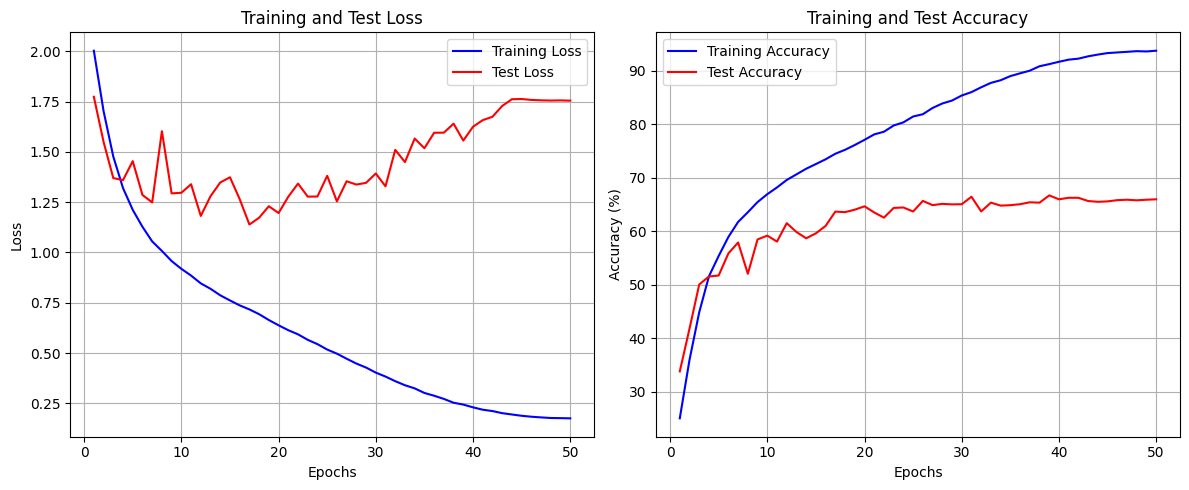


=== Running experiment: patch_size_4x4 ===
Configuration:
  d_model: 384
  n_classes: 10
  img_size: (32, 32)
  patch_size: (4, 4)
  n_channels: 3
  n_heads: 6
  n_layers: 8
  mlp_ratio: 4
  dropout: 0.1
  batch_size: 128
  epochs: 50
  lr: 0.0003
  weight_decay: 0.05
  warmup_steps: 500
  pos_embedding_type: 1d_learned

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000, Test samples: 10000
Model parameters: 14.25M


Epoch 1/50 | Train Loss: 1.9903 | Train Acc: 26.47% | Test Loss: 1.7501 | Test Acc: 33.42%
Saving Best Model at Epoch 1 with Accuracy: 33.42%


Epoch 2/50 | Train Loss: 1.6037 | Train Acc: 39.32% | Test Loss: 1.4017 | Test Acc: 48.54%
Saving Best Model at Epoch 2 with Accuracy: 48.54%


Epoch 3/50 | Train Loss: 1.3093 | Train Acc: 51.53% | Test Loss: 1.1686 | Test Acc: 57.39%
Saving Best Model at Epoch 3 with Accuracy: 57.39%


Epoch 4/50 | Train Loss: 1.1294 | Train Acc: 58.69% | Test Loss: 1.2371 | Test Acc: 56.75%


Epoch 5/50 | Train Loss: 1.0012 | Train Acc: 63.79% | Test Loss: 1.0206 | Test Acc: 63.83%
Saving Best Model at Epoch 5 with Accuracy: 63.83%


Epoch 6/50 | Train Loss: 0.9251 | Train Acc: 66.73% | Test Loss: 1.0861 | Test Acc: 63.19%


Epoch 7/50 | Train Loss: 0.8492 | Train Acc: 69.69% | Test Loss: 0.9057 | Test Acc: 68.69%
Saving Best Model at Epoch 7 with Accuracy: 68.69%


Epoch 8/50 | Train Loss: 0.7950 | Train Acc: 71.75% | Test Loss: 0.9378 | Test Acc: 67.17%


Epoch 9/50 | Train Loss: 0.7533 | Train Acc: 73.17% | Test Loss: 1.0381 | Test Acc: 67.17%


Epoch 10/50 | Train Loss: 0.6969 | Train Acc: 75.12% | Test Loss: 0.9001 | Test Acc: 69.64%
Saving Best Model at Epoch 10 with Accuracy: 69.64%


Epoch 11/50 | Train Loss: 0.6640 | Train Acc: 76.45% | Test Loss: 0.9268 | Test Acc: 69.13%


Epoch 12/50 | Train Loss: 0.6232 | Train Acc: 77.77% | Test Loss: 0.8643 | Test Acc: 71.80%
Saving Best Model at Epoch 12 with Accuracy: 71.80%


Epoch 13/50 | Train Loss: 0.5779 | Train Acc: 79.39% | Test Loss: 0.9476 | Test Acc: 70.35%


Epoch 14/50 | Train Loss: 0.5444 | Train Acc: 80.53% | Test Loss: 0.9519 | Test Acc: 71.21%


Epoch 15/50 | Train Loss: 0.5114 | Train Acc: 81.68% | Test Loss: 0.8970 | Test Acc: 72.16%
Saving Best Model at Epoch 15 with Accuracy: 72.16%


Epoch 16/50 | Train Loss: 0.4713 | Train Acc: 83.15% | Test Loss: 0.9658 | Test Acc: 71.39%


Epoch 17/50 | Train Loss: 0.4333 | Train Acc: 84.51% | Test Loss: 1.0893 | Test Acc: 69.39%


Epoch 18/50 | Train Loss: 0.4077 | Train Acc: 85.32% | Test Loss: 0.9766 | Test Acc: 71.94%


Epoch 19/50 | Train Loss: 0.3727 | Train Acc: 86.66% | Test Loss: 1.0623 | Test Acc: 71.10%


Epoch 20/50 | Train Loss: 0.3467 | Train Acc: 87.61% | Test Loss: 0.9502 | Test Acc: 74.27%
Saving Best Model at Epoch 20 with Accuracy: 74.27%


Epoch 21/50 | Train Loss: 0.3050 | Train Acc: 89.00% | Test Loss: 1.1099 | Test Acc: 72.17%


Epoch 22/50 | Train Loss: 0.2871 | Train Acc: 89.61% | Test Loss: 1.1476 | Test Acc: 72.93%


Epoch 23/50 | Train Loss: 0.2570 | Train Acc: 90.62% | Test Loss: 1.4125 | Test Acc: 69.29%


Epoch 24/50 | Train Loss: 0.2318 | Train Acc: 91.63% | Test Loss: 1.2506 | Test Acc: 71.74%


Epoch 25/50 | Train Loss: 0.2081 | Train Acc: 92.50% | Test Loss: 1.3023 | Test Acc: 72.65%


Epoch 26/50 | Train Loss: 0.1836 | Train Acc: 93.40% | Test Loss: 1.2595 | Test Acc: 73.33%


Epoch 27/50 | Train Loss: 0.1689 | Train Acc: 93.85% | Test Loss: 1.3297 | Test Acc: 72.14%


Epoch 28/50 | Train Loss: 0.1467 | Train Acc: 94.69% | Test Loss: 1.3300 | Test Acc: 73.57%


Epoch 29/50 | Train Loss: 0.1334 | Train Acc: 95.19% | Test Loss: 1.3796 | Test Acc: 73.07%


Epoch 30/50 | Train Loss: 0.1146 | Train Acc: 95.85% | Test Loss: 1.4810 | Test Acc: 72.13%


Epoch 31/50 | Train Loss: 0.1054 | Train Acc: 96.21% | Test Loss: 1.4118 | Test Acc: 73.26%


Epoch 32/50 | Train Loss: 0.0901 | Train Acc: 96.78% | Test Loss: 1.4811 | Test Acc: 73.52%


Epoch 33/50 | Train Loss: 0.0804 | Train Acc: 97.12% | Test Loss: 1.6094 | Test Acc: 73.08%


Epoch 34/50 | Train Loss: 0.0718 | Train Acc: 97.46% | Test Loss: 1.6081 | Test Acc: 73.57%


Epoch 35/50 | Train Loss: 0.0607 | Train Acc: 97.86% | Test Loss: 1.6321 | Test Acc: 73.56%


Epoch 36/50 | Train Loss: 0.0559 | Train Acc: 97.96% | Test Loss: 1.7027 | Test Acc: 73.08%


Epoch 37/50 | Train Loss: 0.0477 | Train Acc: 98.25% | Test Loss: 1.7432 | Test Acc: 72.98%


Epoch 38/50 | Train Loss: 0.0432 | Train Acc: 98.47% | Test Loss: 1.7250 | Test Acc: 74.11%


Epoch 39/50 | Train Loss: 0.0367 | Train Acc: 98.74% | Test Loss: 1.7911 | Test Acc: 73.59%


Epoch 40/50 | Train Loss: 0.0333 | Train Acc: 98.86% | Test Loss: 1.7552 | Test Acc: 74.46%
Saving Best Model at Epoch 40 with Accuracy: 74.46%


Epoch 41/50 | Train Loss: 0.0268 | Train Acc: 99.05% | Test Loss: 1.8159 | Test Acc: 74.18%


Epoch 42/50 | Train Loss: 0.0234 | Train Acc: 99.23% | Test Loss: 1.8648 | Test Acc: 73.94%


Epoch 43/50 | Train Loss: 0.0215 | Train Acc: 99.23% | Test Loss: 1.8276 | Test Acc: 74.46%


Epoch 44/50 | Train Loss: 0.0180 | Train Acc: 99.42% | Test Loss: 1.8398 | Test Acc: 74.63%
Saving Best Model at Epoch 44 with Accuracy: 74.63%


Epoch 45/50 | Train Loss: 0.0189 | Train Acc: 99.38% | Test Loss: 1.8641 | Test Acc: 74.56%


Epoch 46/50 | Train Loss: 0.0169 | Train Acc: 99.45% | Test Loss: 1.8740 | Test Acc: 74.35%


Epoch 47/50 | Train Loss: 0.0156 | Train Acc: 99.48% | Test Loss: 1.8635 | Test Acc: 74.54%


Epoch 48/50 | Train Loss: 0.0144 | Train Acc: 99.55% | Test Loss: 1.8669 | Test Acc: 74.59%


Epoch 49/50 | Train Loss: 0.0138 | Train Acc: 99.55% | Test Loss: 1.8705 | Test Acc: 74.50%


Epoch 50/50 | Train Loss: 0.0150 | Train Acc: 99.51% | Test Loss: 1.8703 | Test Acc: 74.49%

Best Test Accuracy: 74.63% — Model saved to: best_vit_model.pth


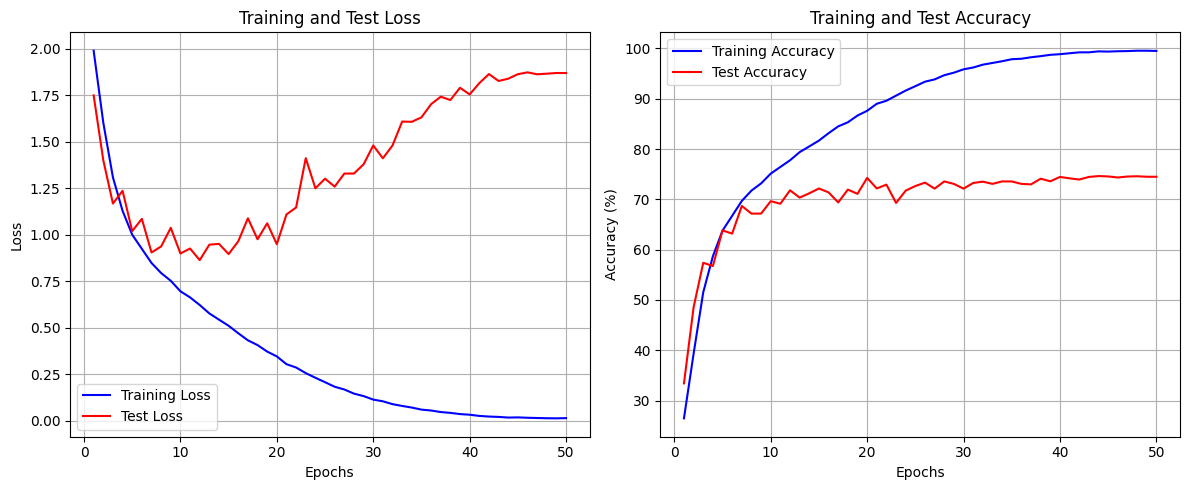


=== Running experiment: patch_size_8x8 ===
Configuration:
  d_model: 512
  n_classes: 10
  img_size: (32, 32)
  patch_size: (8, 8)
  n_channels: 3
  n_heads: 8
  n_layers: 8
  mlp_ratio: 4
  dropout: 0.1
  batch_size: 128
  epochs: 50
  lr: 0.0003
  weight_decay: 0.05
  warmup_steps: 500
  pos_embedding_type: 1d_learned

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000, Test samples: 10000
Model parameters: 25.34M


Epoch 1/50 | Train Loss: 1.9578 | Train Acc: 29.33% | Test Loss: 1.6338 | Test Acc: 38.80%
Saving Best Model at Epoch 1 with Accuracy: 38.80%


Epoch 2/50 | Train Loss: 1.5247 | Train Acc: 43.47% | Test Loss: 1.3925 | Test Acc: 49.24%
Saving Best Model at Epoch 2 with Accuracy: 49.24%


Epoch 3/50 | Train Loss: 1.3215 | Train Acc: 51.75% | Test Loss: 1.2436 | Test Acc: 54.74%
Saving Best Model at Epoch 3 with Accuracy: 54.74%


Epoch 4/50 | Train Loss: 1.1996 | Train Acc: 56.37% | Test Loss: 1.1583 | Test Acc: 58.48%
Saving Best Model at Epoch 4 with Accuracy: 58.48%


Epoch 5/50 | Train Loss: 1.0892 | Train Acc: 60.89% | Test Loss: 1.1071 | Test Acc: 60.53%
Saving Best Model at Epoch 5 with Accuracy: 60.53%


Epoch 6/50 | Train Loss: 1.0104 | Train Acc: 63.71% | Test Loss: 1.0570 | Test Acc: 62.97%
Saving Best Model at Epoch 6 with Accuracy: 62.97%


Epoch 7/50 | Train Loss: 0.9422 | Train Acc: 66.41% | Test Loss: 1.0800 | Test Acc: 62.40%


Epoch 8/50 | Train Loss: 0.8778 | Train Acc: 68.61% | Test Loss: 1.0500 | Test Acc: 63.69%
Saving Best Model at Epoch 8 with Accuracy: 63.69%


Epoch 9/50 | Train Loss: 0.8187 | Train Acc: 70.39% | Test Loss: 1.0064 | Test Acc: 64.99%
Saving Best Model at Epoch 9 with Accuracy: 64.99%


Epoch 10/50 | Train Loss: 0.7681 | Train Acc: 72.40% | Test Loss: 1.0749 | Test Acc: 63.72%


Epoch 11/50 | Train Loss: 0.7133 | Train Acc: 74.68% | Test Loss: 1.0577 | Test Acc: 65.04%
Saving Best Model at Epoch 11 with Accuracy: 65.04%


Epoch 12/50 | Train Loss: 0.6626 | Train Acc: 76.07% | Test Loss: 1.0340 | Test Acc: 65.75%
Saving Best Model at Epoch 12 with Accuracy: 65.75%


Epoch 13/50 | Train Loss: 0.6122 | Train Acc: 78.17% | Test Loss: 1.1118 | Test Acc: 64.49%


Epoch 14/50 | Train Loss: 0.5615 | Train Acc: 79.95% | Test Loss: 1.1148 | Test Acc: 66.20%
Saving Best Model at Epoch 14 with Accuracy: 66.20%


Epoch 15/50 | Train Loss: 0.5191 | Train Acc: 81.44% | Test Loss: 1.0951 | Test Acc: 66.22%
Saving Best Model at Epoch 15 with Accuracy: 66.22%


Epoch 16/50 | Train Loss: 0.4692 | Train Acc: 83.18% | Test Loss: 1.1844 | Test Acc: 66.61%
Saving Best Model at Epoch 16 with Accuracy: 66.61%


Epoch 17/50 | Train Loss: 0.4232 | Train Acc: 84.86% | Test Loss: 1.1895 | Test Acc: 66.63%
Saving Best Model at Epoch 17 with Accuracy: 66.63%


Epoch 18/50 | Train Loss: 0.3832 | Train Acc: 86.10% | Test Loss: 1.1954 | Test Acc: 66.57%


Epoch 19/50 | Train Loss: 0.3441 | Train Acc: 87.68% | Test Loss: 1.2708 | Test Acc: 66.15%


Epoch 20/50 | Train Loss: 0.3103 | Train Acc: 88.80% | Test Loss: 1.2866 | Test Acc: 67.42%
Saving Best Model at Epoch 20 with Accuracy: 67.42%


Epoch 21/50 | Train Loss: 0.2737 | Train Acc: 90.10% | Test Loss: 1.3551 | Test Acc: 67.59%
Saving Best Model at Epoch 21 with Accuracy: 67.59%


Epoch 22/50 | Train Loss: 0.2386 | Train Acc: 91.37% | Test Loss: 1.4187 | Test Acc: 67.86%
Saving Best Model at Epoch 22 with Accuracy: 67.86%


Epoch 23/50 | Train Loss: 0.2154 | Train Acc: 92.30% | Test Loss: 1.4055 | Test Acc: 67.29%


Epoch 24/50 | Train Loss: 0.1859 | Train Acc: 93.38% | Test Loss: 1.5240 | Test Acc: 67.22%


Epoch 25/50 | Train Loss: 0.1625 | Train Acc: 94.06% | Test Loss: 1.6581 | Test Acc: 66.76%


Epoch 26/50 | Train Loss: 0.1485 | Train Acc: 94.68% | Test Loss: 1.6491 | Test Acc: 67.39%


Epoch 27/50 | Train Loss: 0.1296 | Train Acc: 95.36% | Test Loss: 1.6562 | Test Acc: 67.32%


Epoch 28/50 | Train Loss: 0.1154 | Train Acc: 95.86% | Test Loss: 1.7496 | Test Acc: 67.70%


Epoch 29/50 | Train Loss: 0.0984 | Train Acc: 96.54% | Test Loss: 1.7942 | Test Acc: 67.71%


Epoch 30/50 | Train Loss: 0.0830 | Train Acc: 97.02% | Test Loss: 1.9299 | Test Acc: 67.75%


Epoch 31/50 | Train Loss: 0.0752 | Train Acc: 97.35% | Test Loss: 1.9555 | Test Acc: 67.89%
Saving Best Model at Epoch 31 with Accuracy: 67.89%


Epoch 32/50 | Train Loss: 0.0691 | Train Acc: 97.53% | Test Loss: 1.9778 | Test Acc: 67.79%


Epoch 33/50 | Train Loss: 0.0575 | Train Acc: 97.98% | Test Loss: 1.9835 | Test Acc: 68.14%
Saving Best Model at Epoch 33 with Accuracy: 68.14%


Epoch 34/50 | Train Loss: 0.0503 | Train Acc: 98.25% | Test Loss: 2.0665 | Test Acc: 68.20%
Saving Best Model at Epoch 34 with Accuracy: 68.20%


Epoch 35/50 | Train Loss: 0.0418 | Train Acc: 98.56% | Test Loss: 2.0920 | Test Acc: 68.31%
Saving Best Model at Epoch 35 with Accuracy: 68.31%


Epoch 36/50 | Train Loss: 0.0361 | Train Acc: 98.72% | Test Loss: 2.1791 | Test Acc: 67.96%


Epoch 37/50 | Train Loss: 0.0332 | Train Acc: 98.83% | Test Loss: 2.1702 | Test Acc: 68.55%
Saving Best Model at Epoch 37 with Accuracy: 68.55%


Epoch 38/50 | Train Loss: 0.0271 | Train Acc: 98.99% | Test Loss: 2.2419 | Test Acc: 68.56%
Saving Best Model at Epoch 38 with Accuracy: 68.56%


Epoch 39/50 | Train Loss: 0.0233 | Train Acc: 99.22% | Test Loss: 2.3025 | Test Acc: 68.76%
Saving Best Model at Epoch 39 with Accuracy: 68.76%


Epoch 40/50 | Train Loss: 0.0212 | Train Acc: 99.28% | Test Loss: 2.3600 | Test Acc: 68.50%


Epoch 41/50 | Train Loss: 0.0194 | Train Acc: 99.34% | Test Loss: 2.3522 | Test Acc: 68.72%


Epoch 42/50 | Train Loss: 0.0161 | Train Acc: 99.46% | Test Loss: 2.3643 | Test Acc: 68.77%
Saving Best Model at Epoch 42 with Accuracy: 68.77%


Epoch 43/50 | Train Loss: 0.0125 | Train Acc: 99.59% | Test Loss: 2.3998 | Test Acc: 68.81%
Saving Best Model at Epoch 43 with Accuracy: 68.81%


Epoch 44/50 | Train Loss: 0.0117 | Train Acc: 99.59% | Test Loss: 2.4079 | Test Acc: 69.01%
Saving Best Model at Epoch 44 with Accuracy: 69.01%


Epoch 45/50 | Train Loss: 0.0105 | Train Acc: 99.66% | Test Loss: 2.4247 | Test Acc: 69.20%
Saving Best Model at Epoch 45 with Accuracy: 69.20%


Epoch 46/50 | Train Loss: 0.0102 | Train Acc: 99.65% | Test Loss: 2.4376 | Test Acc: 68.92%


Epoch 47/50 | Train Loss: 0.0092 | Train Acc: 99.71% | Test Loss: 2.4350 | Test Acc: 68.96%


Epoch 48/50 | Train Loss: 0.0099 | Train Acc: 99.66% | Test Loss: 2.4410 | Test Acc: 68.82%


Epoch 49/50 | Train Loss: 0.0077 | Train Acc: 99.74% | Test Loss: 2.4429 | Test Acc: 68.87%


Epoch 50/50 | Train Loss: 0.0081 | Train Acc: 99.75% | Test Loss: 2.4438 | Test Acc: 68.86%

Best Test Accuracy: 69.20% — Model saved to: best_vit_model.pth


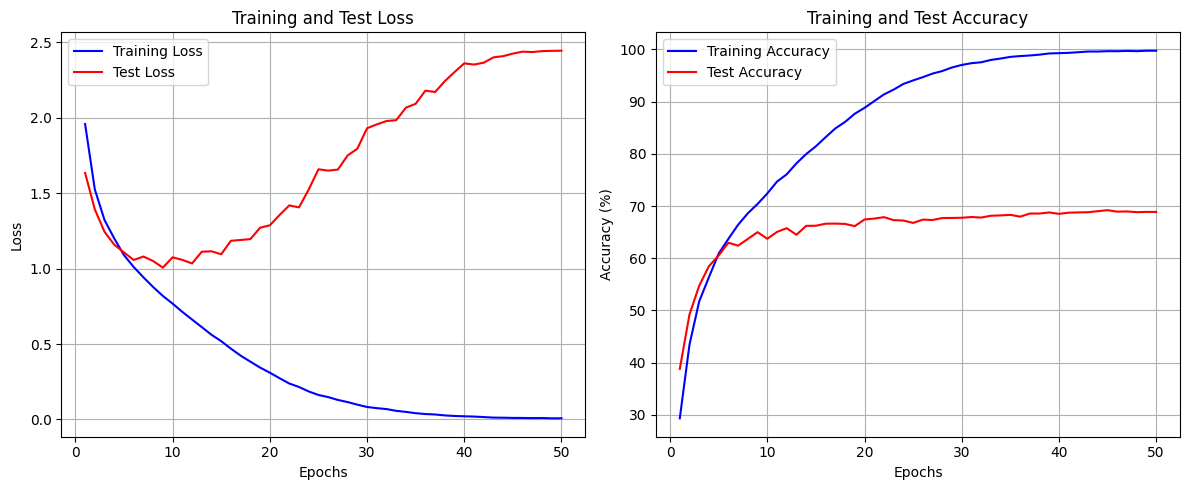

In [6]:
patch_results = patch_size_experiment()


=== Running experiment: hyperparams_1 ===
Configuration:
  d_model: 384
  n_classes: 10
  img_size: (32, 32)
  patch_size: (4, 4)
  n_channels: 3
  n_heads: 6
  n_layers: 8
  mlp_ratio: 4
  dropout: 0.1
  batch_size: 128
  epochs: 50
  lr: 0.0003
  weight_decay: 0.05
  warmup_steps: 500
  pos_embedding_type: 1d_learned

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000, Test samples: 10000
Model parameters: 14.25M


Epoch 1/50 | Train Loss: 1.9659 | Train Acc: 27.48% | Test Loss: 1.6696 | Test Acc: 36.72%
Saving Best Model at Epoch 1 with Accuracy: 36.72%


Epoch 2/50 | Train Loss: 1.5564 | Train Acc: 41.85% | Test Loss: 1.3775 | Test Acc: 48.77%
Saving Best Model at Epoch 2 with Accuracy: 48.77%


Epoch 3/50 | Train Loss: 1.2874 | Train Acc: 52.73% | Test Loss: 1.2179 | Test Acc: 55.68%
Saving Best Model at Epoch 3 with Accuracy: 55.68%


Epoch 4/50 | Train Loss: 1.1190 | Train Acc: 59.24% | Test Loss: 1.0499 | Test Acc: 62.70%
Saving Best Model at Epoch 4 with Accuracy: 62.70%


Epoch 5/50 | Train Loss: 1.0029 | Train Acc: 63.83% | Test Loss: 1.0180 | Test Acc: 63.30%
Saving Best Model at Epoch 5 with Accuracy: 63.30%


Epoch 6/50 | Train Loss: 0.9176 | Train Acc: 67.02% | Test Loss: 0.9166 | Test Acc: 67.67%
Saving Best Model at Epoch 6 with Accuracy: 67.67%


Epoch 7/50 | Train Loss: 0.8499 | Train Acc: 69.45% | Test Loss: 0.9151 | Test Acc: 68.48%
Saving Best Model at Epoch 7 with Accuracy: 68.48%


Epoch 8/50 | Train Loss: 0.7912 | Train Acc: 71.74% | Test Loss: 0.9630 | Test Acc: 67.41%


Epoch 9/50 | Train Loss: 0.7366 | Train Acc: 73.69% | Test Loss: 0.8547 | Test Acc: 70.71%
Saving Best Model at Epoch 9 with Accuracy: 70.71%


Epoch 10/50 | Train Loss: 0.6993 | Train Acc: 75.00% | Test Loss: 0.8604 | Test Acc: 71.12%
Saving Best Model at Epoch 10 with Accuracy: 71.12%


Epoch 11/50 | Train Loss: 0.6541 | Train Acc: 76.72% | Test Loss: 0.8634 | Test Acc: 71.18%
Saving Best Model at Epoch 11 with Accuracy: 71.18%


Epoch 12/50 | Train Loss: 0.6143 | Train Acc: 78.05% | Test Loss: 0.8427 | Test Acc: 72.18%
Saving Best Model at Epoch 12 with Accuracy: 72.18%


Epoch 13/50 | Train Loss: 0.5724 | Train Acc: 79.54% | Test Loss: 0.8237 | Test Acc: 71.57%


Epoch 14/50 | Train Loss: 0.5423 | Train Acc: 80.69% | Test Loss: 0.9165 | Test Acc: 71.22%


Epoch 15/50 | Train Loss: 0.4991 | Train Acc: 82.03% | Test Loss: 0.8550 | Test Acc: 72.40%
Saving Best Model at Epoch 15 with Accuracy: 72.40%


Epoch 16/50 | Train Loss: 0.4672 | Train Acc: 83.07% | Test Loss: 0.8676 | Test Acc: 73.27%
Saving Best Model at Epoch 16 with Accuracy: 73.27%


Epoch 17/50 | Train Loss: 0.4303 | Train Acc: 84.60% | Test Loss: 0.8666 | Test Acc: 72.97%


Epoch 18/50 | Train Loss: 0.3958 | Train Acc: 85.74% | Test Loss: 0.9594 | Test Acc: 71.71%


Epoch 19/50 | Train Loss: 0.3586 | Train Acc: 87.14% | Test Loss: 0.9407 | Test Acc: 73.12%


Epoch 20/50 | Train Loss: 0.3341 | Train Acc: 88.09% | Test Loss: 1.0578 | Test Acc: 72.06%


Epoch 21/50 | Train Loss: 0.2985 | Train Acc: 89.22% | Test Loss: 1.0235 | Test Acc: 73.60%
Saving Best Model at Epoch 21 with Accuracy: 73.60%


Epoch 22/50 | Train Loss: 0.2710 | Train Acc: 90.15% | Test Loss: 1.1067 | Test Acc: 72.56%


Epoch 23/50 | Train Loss: 0.2444 | Train Acc: 91.21% | Test Loss: 1.0474 | Test Acc: 73.62%
Saving Best Model at Epoch 23 with Accuracy: 73.62%


Epoch 24/50 | Train Loss: 0.2177 | Train Acc: 92.05% | Test Loss: 1.1710 | Test Acc: 71.90%


Epoch 25/50 | Train Loss: 0.1985 | Train Acc: 92.88% | Test Loss: 1.1020 | Test Acc: 74.34%
Saving Best Model at Epoch 25 with Accuracy: 74.34%


Epoch 26/50 | Train Loss: 0.1785 | Train Acc: 93.50% | Test Loss: 1.1347 | Test Acc: 74.14%


Epoch 27/50 | Train Loss: 0.1537 | Train Acc: 94.51% | Test Loss: 1.2118 | Test Acc: 74.39%
Saving Best Model at Epoch 27 with Accuracy: 74.39%


Epoch 28/50 | Train Loss: 0.1385 | Train Acc: 95.01% | Test Loss: 1.2499 | Test Acc: 73.61%


Epoch 29/50 | Train Loss: 0.1245 | Train Acc: 95.51% | Test Loss: 1.2540 | Test Acc: 74.05%


Epoch 30/50 | Train Loss: 0.1097 | Train Acc: 96.01% | Test Loss: 1.3190 | Test Acc: 74.37%


Epoch 31/50 | Train Loss: 0.0967 | Train Acc: 96.50% | Test Loss: 1.3818 | Test Acc: 74.22%


Epoch 32/50 | Train Loss: 0.0842 | Train Acc: 96.96% | Test Loss: 1.4459 | Test Acc: 74.12%


Epoch 33/50 | Train Loss: 0.0724 | Train Acc: 97.32% | Test Loss: 1.4970 | Test Acc: 74.06%


Epoch 34/50 | Train Loss: 0.0676 | Train Acc: 97.60% | Test Loss: 1.4983 | Test Acc: 74.26%


Epoch 35/50 | Train Loss: 0.0564 | Train Acc: 97.97% | Test Loss: 1.5421 | Test Acc: 74.33%


Epoch 36/50 | Train Loss: 0.0485 | Train Acc: 98.29% | Test Loss: 1.5775 | Test Acc: 74.77%
Saving Best Model at Epoch 36 with Accuracy: 74.77%


Epoch 37/50 | Train Loss: 0.0398 | Train Acc: 98.58% | Test Loss: 1.6802 | Test Acc: 74.05%


Epoch 38/50 | Train Loss: 0.0368 | Train Acc: 98.73% | Test Loss: 1.6763 | Test Acc: 74.55%


Epoch 39/50 | Train Loss: 0.0311 | Train Acc: 98.90% | Test Loss: 1.6964 | Test Acc: 75.21%
Saving Best Model at Epoch 39 with Accuracy: 75.21%


Epoch 40/50 | Train Loss: 0.0297 | Train Acc: 98.95% | Test Loss: 1.6996 | Test Acc: 75.04%


Epoch 41/50 | Train Loss: 0.0255 | Train Acc: 99.08% | Test Loss: 1.7179 | Test Acc: 75.03%


Epoch 42/50 | Train Loss: 0.0198 | Train Acc: 99.29% | Test Loss: 1.7588 | Test Acc: 75.04%


Epoch 43/50 | Train Loss: 0.0185 | Train Acc: 99.34% | Test Loss: 1.7447 | Test Acc: 75.40%
Saving Best Model at Epoch 43 with Accuracy: 75.40%


Epoch 44/50 | Train Loss: 0.0165 | Train Acc: 99.47% | Test Loss: 1.7620 | Test Acc: 75.35%


Epoch 45/50 | Train Loss: 0.0160 | Train Acc: 99.43% | Test Loss: 1.7815 | Test Acc: 75.32%


Epoch 46/50 | Train Loss: 0.0139 | Train Acc: 99.52% | Test Loss: 1.7893 | Test Acc: 75.36%


Epoch 47/50 | Train Loss: 0.0132 | Train Acc: 99.57% | Test Loss: 1.7931 | Test Acc: 75.39%


Epoch 48/50 | Train Loss: 0.0133 | Train Acc: 99.56% | Test Loss: 1.7963 | Test Acc: 75.26%


Epoch 49/50 | Train Loss: 0.0119 | Train Acc: 99.59% | Test Loss: 1.7964 | Test Acc: 75.26%


Epoch 50/50 | Train Loss: 0.0117 | Train Acc: 99.62% | Test Loss: 1.7975 | Test Acc: 75.28%

Best Test Accuracy: 75.40% — Model saved to: best_vit_model.pth


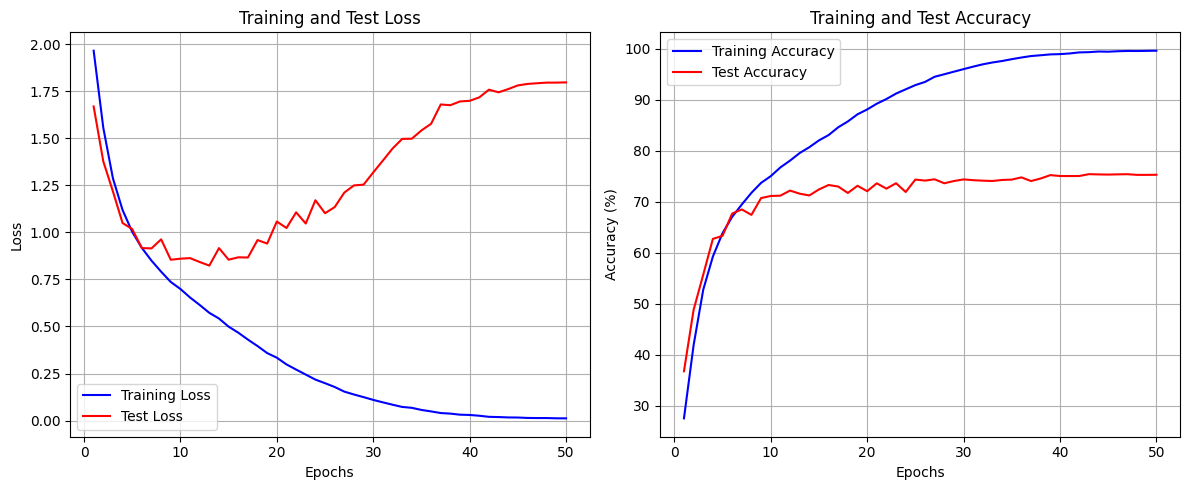


=== Running experiment: hyperparams_2 ===
Configuration:
  d_model: 384
  n_classes: 10
  img_size: (32, 32)
  patch_size: (4, 4)
  n_channels: 3
  n_heads: 6
  n_layers: 12
  mlp_ratio: 4
  dropout: 0.1
  batch_size: 128
  epochs: 50
  lr: 0.0002
  weight_decay: 0.05
  warmup_steps: 500
  pos_embedding_type: 1d_learned

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000, Test samples: 10000
Model parameters: 21.35M


Epoch 1/50 | Train Loss: 1.9883 | Train Acc: 26.37% | Test Loss: 1.7207 | Test Acc: 34.61%
Saving Best Model at Epoch 1 with Accuracy: 34.61%


Epoch 2/50 | Train Loss: 1.6436 | Train Acc: 37.95% | Test Loss: 1.4860 | Test Acc: 45.44%
Saving Best Model at Epoch 2 with Accuracy: 45.44%


Epoch 3/50 | Train Loss: 1.3812 | Train Acc: 48.92% | Test Loss: 1.2905 | Test Acc: 52.40%
Saving Best Model at Epoch 3 with Accuracy: 52.40%


Epoch 4/50 | Train Loss: 1.2012 | Train Acc: 56.19% | Test Loss: 1.2065 | Test Acc: 56.94%
Saving Best Model at Epoch 4 with Accuracy: 56.94%


Epoch 5/50 | Train Loss: 1.0786 | Train Acc: 60.88% | Test Loss: 1.0648 | Test Acc: 61.83%
Saving Best Model at Epoch 5 with Accuracy: 61.83%


Epoch 6/50 | Train Loss: 0.9708 | Train Acc: 65.03% | Test Loss: 1.0510 | Test Acc: 64.11%
Saving Best Model at Epoch 6 with Accuracy: 64.11%


Epoch 7/50 | Train Loss: 0.9041 | Train Acc: 67.43% | Test Loss: 0.9370 | Test Acc: 67.57%
Saving Best Model at Epoch 7 with Accuracy: 67.57%


Epoch 8/50 | Train Loss: 0.8396 | Train Acc: 69.97% | Test Loss: 0.9760 | Test Acc: 65.92%


Epoch 9/50 | Train Loss: 0.7955 | Train Acc: 71.61% | Test Loss: 1.0449 | Test Acc: 64.59%


Epoch 10/50 | Train Loss: 0.7419 | Train Acc: 73.80% | Test Loss: 0.9426 | Test Acc: 68.40%
Saving Best Model at Epoch 10 with Accuracy: 68.40%


Epoch 11/50 | Train Loss: 0.6995 | Train Acc: 75.11% | Test Loss: 0.8876 | Test Acc: 70.76%
Saving Best Model at Epoch 11 with Accuracy: 70.76%


Epoch 12/50 | Train Loss: 0.6599 | Train Acc: 76.42% | Test Loss: 1.0379 | Test Acc: 67.17%


Epoch 13/50 | Train Loss: 0.6254 | Train Acc: 77.66% | Test Loss: 0.9211 | Test Acc: 70.42%


Epoch 14/50 | Train Loss: 0.5864 | Train Acc: 78.94% | Test Loss: 0.9604 | Test Acc: 69.62%


Epoch 15/50 | Train Loss: 0.5540 | Train Acc: 80.27% | Test Loss: 0.9227 | Test Acc: 71.14%
Saving Best Model at Epoch 15 with Accuracy: 71.14%


Epoch 16/50 | Train Loss: 0.5187 | Train Acc: 81.37% | Test Loss: 0.8968 | Test Acc: 72.66%
Saving Best Model at Epoch 16 with Accuracy: 72.66%


Epoch 17/50 | Train Loss: 0.4838 | Train Acc: 82.54% | Test Loss: 0.9410 | Test Acc: 71.52%


Epoch 18/50 | Train Loss: 0.4457 | Train Acc: 84.17% | Test Loss: 1.0183 | Test Acc: 71.53%


Epoch 19/50 | Train Loss: 0.4213 | Train Acc: 85.04% | Test Loss: 0.9342 | Test Acc: 73.16%
Saving Best Model at Epoch 19 with Accuracy: 73.16%


Epoch 20/50 | Train Loss: 0.3885 | Train Acc: 86.08% | Test Loss: 1.0105 | Test Acc: 71.98%


Epoch 21/50 | Train Loss: 0.3619 | Train Acc: 86.94% | Test Loss: 1.0475 | Test Acc: 71.68%


Epoch 22/50 | Train Loss: 0.3300 | Train Acc: 88.15% | Test Loss: 1.0645 | Test Acc: 72.83%


Epoch 23/50 | Train Loss: 0.3065 | Train Acc: 88.94% | Test Loss: 1.1146 | Test Acc: 71.41%


Epoch 24/50 | Train Loss: 0.2819 | Train Acc: 89.81% | Test Loss: 1.1916 | Test Acc: 71.78%


Epoch 25/50 | Train Loss: 0.2554 | Train Acc: 90.77% | Test Loss: 1.1261 | Test Acc: 72.87%


Epoch 26/50 | Train Loss: 0.2321 | Train Acc: 91.70% | Test Loss: 1.2440 | Test Acc: 72.01%


Epoch 27/50 | Train Loss: 0.2099 | Train Acc: 92.43% | Test Loss: 1.2376 | Test Acc: 72.59%


Epoch 28/50 | Train Loss: 0.1940 | Train Acc: 92.95% | Test Loss: 1.2810 | Test Acc: 72.53%


Epoch 29/50 | Train Loss: 0.1711 | Train Acc: 93.78% | Test Loss: 1.3048 | Test Acc: 72.94%


Epoch 30/50 | Train Loss: 0.1515 | Train Acc: 94.51% | Test Loss: 1.3829 | Test Acc: 72.79%


Epoch 31/50 | Train Loss: 0.1386 | Train Acc: 94.99% | Test Loss: 1.3625 | Test Acc: 73.10%


Epoch 32/50 | Train Loss: 0.1189 | Train Acc: 95.68% | Test Loss: 1.4848 | Test Acc: 73.17%
Saving Best Model at Epoch 32 with Accuracy: 73.17%


Epoch 33/50 | Train Loss: 0.1090 | Train Acc: 96.06% | Test Loss: 1.4524 | Test Acc: 74.26%
Saving Best Model at Epoch 33 with Accuracy: 74.26%


Epoch 34/50 | Train Loss: 0.0987 | Train Acc: 96.50% | Test Loss: 1.5573 | Test Acc: 73.29%


Epoch 35/50 | Train Loss: 0.0865 | Train Acc: 96.93% | Test Loss: 1.5749 | Test Acc: 73.62%


Epoch 36/50 | Train Loss: 0.0797 | Train Acc: 97.10% | Test Loss: 1.5692 | Test Acc: 73.90%


Epoch 37/50 | Train Loss: 0.0682 | Train Acc: 97.60% | Test Loss: 1.6571 | Test Acc: 73.44%


Epoch 38/50 | Train Loss: 0.0608 | Train Acc: 97.87% | Test Loss: 1.7651 | Test Acc: 73.21%


Epoch 39/50 | Train Loss: 0.0539 | Train Acc: 98.10% | Test Loss: 1.7100 | Test Acc: 74.35%
Saving Best Model at Epoch 39 with Accuracy: 74.35%


Epoch 40/50 | Train Loss: 0.0507 | Train Acc: 98.19% | Test Loss: 1.7436 | Test Acc: 74.28%


Epoch 41/50 | Train Loss: 0.0423 | Train Acc: 98.51% | Test Loss: 1.7728 | Test Acc: 74.67%
Saving Best Model at Epoch 41 with Accuracy: 74.67%


Epoch 42/50 | Train Loss: 0.0394 | Train Acc: 98.70% | Test Loss: 1.8134 | Test Acc: 74.28%


Epoch 43/50 | Train Loss: 0.0338 | Train Acc: 98.83% | Test Loss: 1.8490 | Test Acc: 74.54%


Epoch 44/50 | Train Loss: 0.0338 | Train Acc: 98.83% | Test Loss: 1.8371 | Test Acc: 74.80%
Saving Best Model at Epoch 44 with Accuracy: 74.80%


Epoch 45/50 | Train Loss: 0.0301 | Train Acc: 98.92% | Test Loss: 1.8713 | Test Acc: 74.54%


Epoch 46/50 | Train Loss: 0.0281 | Train Acc: 99.02% | Test Loss: 1.8539 | Test Acc: 74.77%


Epoch 47/50 | Train Loss: 0.0269 | Train Acc: 99.02% | Test Loss: 1.8729 | Test Acc: 74.69%


Epoch 48/50 | Train Loss: 0.0241 | Train Acc: 99.16% | Test Loss: 1.8762 | Test Acc: 74.67%


Epoch 49/50 | Train Loss: 0.0250 | Train Acc: 99.14% | Test Loss: 1.8801 | Test Acc: 74.66%


Epoch 50/50 | Train Loss: 0.0247 | Train Acc: 99.17% | Test Loss: 1.8793 | Test Acc: 74.65%

Best Test Accuracy: 74.80% — Model saved to: best_vit_model.pth


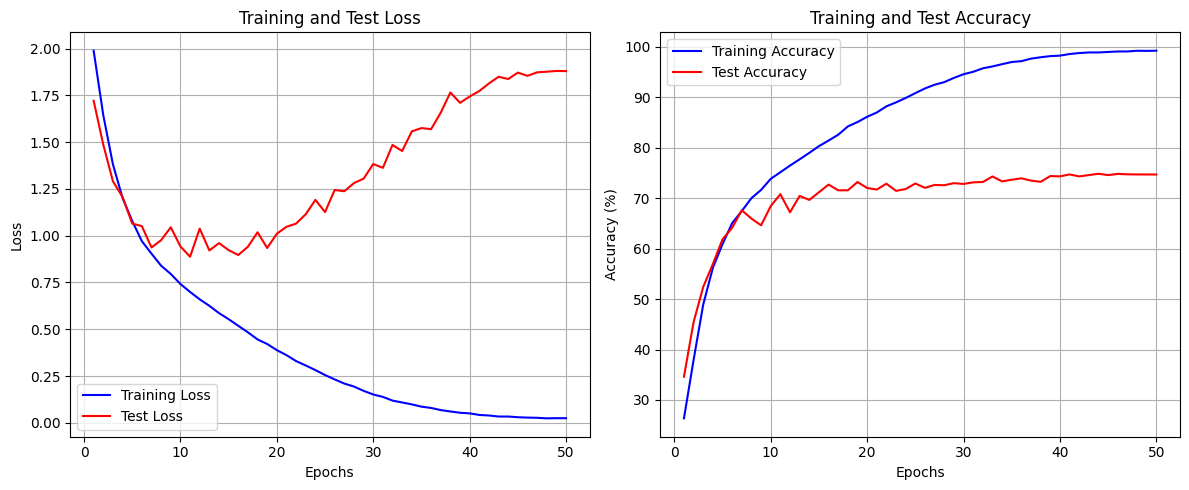


=== Running experiment: hyperparams_3 ===
Configuration:
  d_model: 512
  n_classes: 10
  img_size: (32, 32)
  patch_size: (4, 4)
  n_channels: 3
  n_heads: 8
  n_layers: 8
  mlp_ratio: 4
  dropout: 0.1
  batch_size: 128
  epochs: 50
  lr: 0.0002
  weight_decay: 0.05
  warmup_steps: 500
  pos_embedding_type: 1d_learned

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000, Test samples: 10000
Model parameters: 25.29M


Epoch 1/50 | Train Loss: 2.0276 | Train Acc: 26.06% | Test Loss: 1.7489 | Test Acc: 34.61%
Saving Best Model at Epoch 1 with Accuracy: 34.61%


Epoch 2/50 | Train Loss: 1.6413 | Train Acc: 38.21% | Test Loss: 1.5301 | Test Acc: 42.85%
Saving Best Model at Epoch 2 with Accuracy: 42.85%


Epoch 3/50 | Train Loss: 1.3728 | Train Acc: 49.04% | Test Loss: 1.2354 | Test Acc: 54.72%
Saving Best Model at Epoch 3 with Accuracy: 54.72%


Epoch 4/50 | Train Loss: 1.1633 | Train Acc: 57.69% | Test Loss: 1.1537 | Test Acc: 57.48%
Saving Best Model at Epoch 4 with Accuracy: 57.48%


Epoch 5/50 | Train Loss: 1.0313 | Train Acc: 62.72% | Test Loss: 1.0352 | Test Acc: 62.87%
Saving Best Model at Epoch 5 with Accuracy: 62.87%


Epoch 6/50 | Train Loss: 0.9202 | Train Acc: 66.83% | Test Loss: 1.0274 | Test Acc: 64.53%
Saving Best Model at Epoch 6 with Accuracy: 64.53%


Epoch 7/50 | Train Loss: 0.8518 | Train Acc: 69.65% | Test Loss: 0.9309 | Test Acc: 67.94%
Saving Best Model at Epoch 7 with Accuracy: 67.94%


Epoch 8/50 | Train Loss: 0.7890 | Train Acc: 71.90% | Test Loss: 1.0291 | Test Acc: 66.36%


Epoch 9/50 | Train Loss: 0.7355 | Train Acc: 73.66% | Test Loss: 0.9235 | Test Acc: 68.86%
Saving Best Model at Epoch 9 with Accuracy: 68.86%


Epoch 10/50 | Train Loss: 0.6945 | Train Acc: 75.23% | Test Loss: 0.9328 | Test Acc: 69.96%
Saving Best Model at Epoch 10 with Accuracy: 69.96%


Epoch 11/50 | Train Loss: 0.6439 | Train Acc: 76.97% | Test Loss: 0.9007 | Test Acc: 71.49%
Saving Best Model at Epoch 11 with Accuracy: 71.49%


Epoch 12/50 | Train Loss: 0.6064 | Train Acc: 78.39% | Test Loss: 0.9226 | Test Acc: 71.35%


Epoch 13/50 | Train Loss: 0.5586 | Train Acc: 80.10% | Test Loss: 0.8666 | Test Acc: 72.30%
Saving Best Model at Epoch 13 with Accuracy: 72.30%


Epoch 14/50 | Train Loss: 0.5212 | Train Acc: 81.27% | Test Loss: 0.9552 | Test Acc: 71.38%


Epoch 15/50 | Train Loss: 0.4817 | Train Acc: 82.81% | Test Loss: 0.9704 | Test Acc: 71.77%


Epoch 16/50 | Train Loss: 0.4402 | Train Acc: 84.29% | Test Loss: 1.0785 | Test Acc: 69.84%


Epoch 17/50 | Train Loss: 0.4075 | Train Acc: 85.20% | Test Loss: 1.0482 | Test Acc: 71.43%


Epoch 18/50 | Train Loss: 0.3717 | Train Acc: 86.71% | Test Loss: 1.1598 | Test Acc: 70.64%


Epoch 19/50 | Train Loss: 0.3397 | Train Acc: 87.68% | Test Loss: 1.0707 | Test Acc: 72.61%
Saving Best Model at Epoch 19 with Accuracy: 72.61%


Epoch 20/50 | Train Loss: 0.3058 | Train Acc: 89.01% | Test Loss: 1.1758 | Test Acc: 71.44%


Epoch 21/50 | Train Loss: 0.2696 | Train Acc: 90.35% | Test Loss: 1.2303 | Test Acc: 70.83%


Epoch 22/50 | Train Loss: 0.2405 | Train Acc: 91.38% | Test Loss: 1.2556 | Test Acc: 72.25%


Epoch 23/50 | Train Loss: 0.2219 | Train Acc: 91.87% | Test Loss: 1.2939 | Test Acc: 72.74%
Saving Best Model at Epoch 23 with Accuracy: 72.74%


Epoch 24/50 | Train Loss: 0.1935 | Train Acc: 92.94% | Test Loss: 1.2713 | Test Acc: 73.23%
Saving Best Model at Epoch 24 with Accuracy: 73.23%


Epoch 25/50 | Train Loss: 0.1677 | Train Acc: 93.99% | Test Loss: 1.3945 | Test Acc: 73.19%


Epoch 26/50 | Train Loss: 0.1519 | Train Acc: 94.52% | Test Loss: 1.5681 | Test Acc: 71.60%


Epoch 27/50 | Train Loss: 0.1282 | Train Acc: 95.45% | Test Loss: 1.5088 | Test Acc: 72.72%


Epoch 28/50 | Train Loss: 0.1129 | Train Acc: 95.89% | Test Loss: 1.5256 | Test Acc: 72.91%


Epoch 29/50 | Train Loss: 0.0965 | Train Acc: 96.57% | Test Loss: 1.5356 | Test Acc: 73.78%
Saving Best Model at Epoch 29 with Accuracy: 73.78%


Epoch 30/50 | Train Loss: 0.0908 | Train Acc: 96.79% | Test Loss: 1.5928 | Test Acc: 73.34%


Epoch 31/50 | Train Loss: 0.0731 | Train Acc: 97.35% | Test Loss: 1.7023 | Test Acc: 73.81%
Saving Best Model at Epoch 31 with Accuracy: 73.81%


Epoch 32/50 | Train Loss: 0.0637 | Train Acc: 97.70% | Test Loss: 1.7049 | Test Acc: 73.73%


Epoch 33/50 | Train Loss: 0.0561 | Train Acc: 97.95% | Test Loss: 1.7760 | Test Acc: 73.40%


Epoch 34/50 | Train Loss: 0.0461 | Train Acc: 98.35% | Test Loss: 1.7833 | Test Acc: 74.07%
Saving Best Model at Epoch 34 with Accuracy: 74.07%


Epoch 35/50 | Train Loss: 0.0420 | Train Acc: 98.53% | Test Loss: 1.8886 | Test Acc: 73.56%


Epoch 36/50 | Train Loss: 0.0359 | Train Acc: 98.70% | Test Loss: 1.9070 | Test Acc: 74.38%
Saving Best Model at Epoch 36 with Accuracy: 74.38%


Epoch 37/50 | Train Loss: 0.0301 | Train Acc: 98.92% | Test Loss: 2.0610 | Test Acc: 73.22%


Epoch 38/50 | Train Loss: 0.0265 | Train Acc: 99.10% | Test Loss: 2.0728 | Test Acc: 73.59%


Epoch 39/50 | Train Loss: 0.0236 | Train Acc: 99.15% | Test Loss: 2.0763 | Test Acc: 74.24%


Epoch 40/50 | Train Loss: 0.0189 | Train Acc: 99.32% | Test Loss: 2.1077 | Test Acc: 74.40%
Saving Best Model at Epoch 40 with Accuracy: 74.40%


Epoch 41/50 | Train Loss: 0.0178 | Train Acc: 99.36% | Test Loss: 2.0891 | Test Acc: 74.74%
Saving Best Model at Epoch 41 with Accuracy: 74.74%


Epoch 42/50 | Train Loss: 0.0150 | Train Acc: 99.52% | Test Loss: 2.0855 | Test Acc: 74.90%
Saving Best Model at Epoch 42 with Accuracy: 74.90%


Epoch 43/50 | Train Loss: 0.0121 | Train Acc: 99.59% | Test Loss: 2.0798 | Test Acc: 74.99%
Saving Best Model at Epoch 43 with Accuracy: 74.99%


Epoch 44/50 | Train Loss: 0.0101 | Train Acc: 99.68% | Test Loss: 2.1955 | Test Acc: 74.55%


Epoch 45/50 | Train Loss: 0.0095 | Train Acc: 99.70% | Test Loss: 2.1604 | Test Acc: 74.66%


Epoch 46/50 | Train Loss: 0.0096 | Train Acc: 99.69% | Test Loss: 2.1811 | Test Acc: 74.66%


Epoch 47/50 | Train Loss: 0.0080 | Train Acc: 99.76% | Test Loss: 2.1835 | Test Acc: 74.66%


Epoch 48/50 | Train Loss: 0.0071 | Train Acc: 99.79% | Test Loss: 2.1901 | Test Acc: 74.67%


Epoch 49/50 | Train Loss: 0.0070 | Train Acc: 99.78% | Test Loss: 2.1776 | Test Acc: 74.68%


Epoch 50/50 | Train Loss: 0.0072 | Train Acc: 99.75% | Test Loss: 2.1774 | Test Acc: 74.72%

Best Test Accuracy: 74.99% — Model saved to: best_vit_model.pth


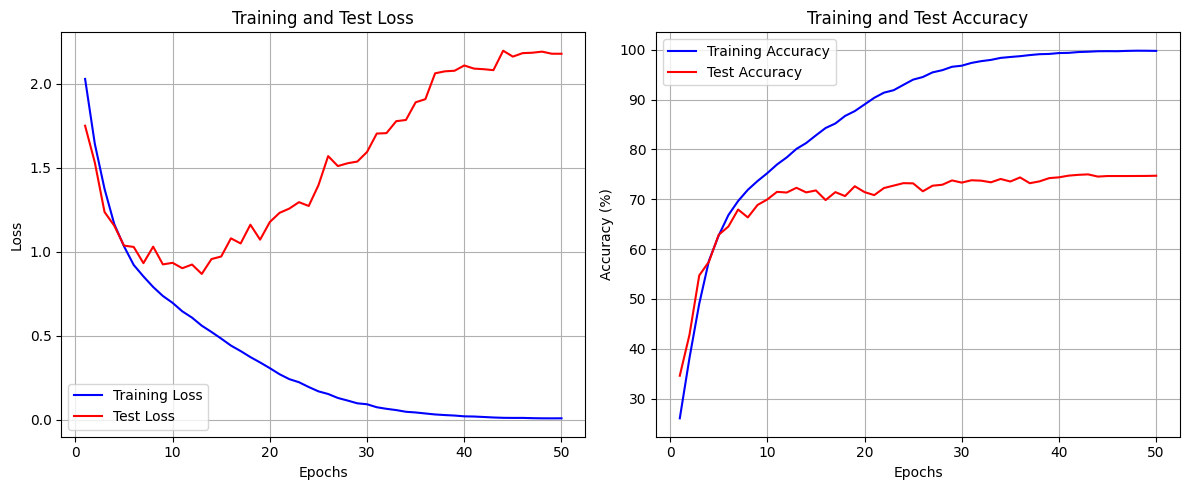


=== Running experiment: hyperparams_4 ===
Configuration:
  d_model: 384
  n_classes: 10
  img_size: (32, 32)
  patch_size: (4, 4)
  n_channels: 3
  n_heads: 6
  n_layers: 8
  mlp_ratio: 6
  dropout: 0.1
  batch_size: 128
  epochs: 50
  lr: 0.0003
  weight_decay: 0.05
  warmup_steps: 500
  pos_embedding_type: 1d_learned

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000, Test samples: 10000
Model parameters: 18.97M


Epoch 1/50 | Train Loss: 1.9845 | Train Acc: 27.19% | Test Loss: 1.7381 | Test Acc: 34.29%
Saving Best Model at Epoch 1 with Accuracy: 34.29%


Epoch 2/50 | Train Loss: 1.5841 | Train Acc: 40.11% | Test Loss: 1.3869 | Test Acc: 49.59%
Saving Best Model at Epoch 2 with Accuracy: 49.59%


Epoch 3/50 | Train Loss: 1.2994 | Train Acc: 52.00% | Test Loss: 1.1889 | Test Acc: 56.73%
Saving Best Model at Epoch 3 with Accuracy: 56.73%


Epoch 4/50 | Train Loss: 1.1312 | Train Acc: 58.71% | Test Loss: 1.0477 | Test Acc: 62.60%
Saving Best Model at Epoch 4 with Accuracy: 62.60%


Epoch 5/50 | Train Loss: 1.0076 | Train Acc: 63.60% | Test Loss: 1.0566 | Test Acc: 62.81%
Saving Best Model at Epoch 5 with Accuracy: 62.81%


Epoch 6/50 | Train Loss: 0.9242 | Train Acc: 66.76% | Test Loss: 0.9089 | Test Acc: 68.03%
Saving Best Model at Epoch 6 with Accuracy: 68.03%


Epoch 7/50 | Train Loss: 0.8522 | Train Acc: 69.45% | Test Loss: 0.8752 | Test Acc: 69.11%
Saving Best Model at Epoch 7 with Accuracy: 69.11%


Epoch 8/50 | Train Loss: 0.7990 | Train Acc: 71.34% | Test Loss: 0.8642 | Test Acc: 70.17%
Saving Best Model at Epoch 8 with Accuracy: 70.17%


Epoch 9/50 | Train Loss: 0.7437 | Train Acc: 73.53% | Test Loss: 0.9049 | Test Acc: 68.90%


Epoch 10/50 | Train Loss: 0.7006 | Train Acc: 74.95% | Test Loss: 0.8588 | Test Acc: 70.93%
Saving Best Model at Epoch 10 with Accuracy: 70.93%


Epoch 11/50 | Train Loss: 0.6493 | Train Acc: 76.77% | Test Loss: 0.8491 | Test Acc: 71.98%
Saving Best Model at Epoch 11 with Accuracy: 71.98%


Epoch 12/50 | Train Loss: 0.6069 | Train Acc: 78.31% | Test Loss: 0.8701 | Test Acc: 71.76%


Epoch 13/50 | Train Loss: 0.5730 | Train Acc: 79.58% | Test Loss: 0.8805 | Test Acc: 72.36%
Saving Best Model at Epoch 13 with Accuracy: 72.36%


Epoch 14/50 | Train Loss: 0.5201 | Train Acc: 81.47% | Test Loss: 0.8696 | Test Acc: 72.32%


Epoch 15/50 | Train Loss: 0.4876 | Train Acc: 82.59% | Test Loss: 0.9347 | Test Acc: 71.43%


Epoch 16/50 | Train Loss: 0.4497 | Train Acc: 83.84% | Test Loss: 0.8969 | Test Acc: 72.89%
Saving Best Model at Epoch 16 with Accuracy: 72.89%


Epoch 17/50 | Train Loss: 0.4096 | Train Acc: 85.31% | Test Loss: 0.9182 | Test Acc: 72.33%


Epoch 18/50 | Train Loss: 0.3704 | Train Acc: 86.74% | Test Loss: 1.0054 | Test Acc: 72.23%


Epoch 19/50 | Train Loss: 0.3356 | Train Acc: 87.85% | Test Loss: 0.9518 | Test Acc: 72.96%
Saving Best Model at Epoch 19 with Accuracy: 72.96%


Epoch 20/50 | Train Loss: 0.3047 | Train Acc: 89.04% | Test Loss: 1.0159 | Test Acc: 71.86%


Epoch 21/50 | Train Loss: 0.2720 | Train Acc: 90.18% | Test Loss: 1.1269 | Test Acc: 72.51%


Epoch 22/50 | Train Loss: 0.2441 | Train Acc: 91.31% | Test Loss: 1.1741 | Test Acc: 72.10%


Epoch 23/50 | Train Loss: 0.2161 | Train Acc: 92.14% | Test Loss: 1.1469 | Test Acc: 72.77%


Epoch 24/50 | Train Loss: 0.1915 | Train Acc: 93.15% | Test Loss: 1.2364 | Test Acc: 72.22%


Epoch 25/50 | Train Loss: 0.1735 | Train Acc: 93.79% | Test Loss: 1.2850 | Test Acc: 72.91%


Epoch 26/50 | Train Loss: 0.1471 | Train Acc: 94.73% | Test Loss: 1.2985 | Test Acc: 73.36%
Saving Best Model at Epoch 26 with Accuracy: 73.36%


Epoch 27/50 | Train Loss: 0.1346 | Train Acc: 95.15% | Test Loss: 1.3004 | Test Acc: 74.10%
Saving Best Model at Epoch 27 with Accuracy: 74.10%


Epoch 28/50 | Train Loss: 0.1136 | Train Acc: 95.94% | Test Loss: 1.4331 | Test Acc: 72.47%


Epoch 29/50 | Train Loss: 0.1046 | Train Acc: 96.20% | Test Loss: 1.4183 | Test Acc: 73.63%


Epoch 30/50 | Train Loss: 0.0855 | Train Acc: 96.99% | Test Loss: 1.5474 | Test Acc: 73.34%


Epoch 31/50 | Train Loss: 0.0801 | Train Acc: 97.15% | Test Loss: 1.4698 | Test Acc: 74.22%
Saving Best Model at Epoch 31 with Accuracy: 74.22%


Epoch 32/50 | Train Loss: 0.0683 | Train Acc: 97.58% | Test Loss: 1.5428 | Test Acc: 73.80%


Epoch 33/50 | Train Loss: 0.0652 | Train Acc: 97.64% | Test Loss: 1.5589 | Test Acc: 74.18%


Epoch 34/50 | Train Loss: 0.0523 | Train Acc: 98.12% | Test Loss: 1.6561 | Test Acc: 73.44%


Epoch 35/50 | Train Loss: 0.0459 | Train Acc: 98.30% | Test Loss: 1.7243 | Test Acc: 73.77%


Epoch 36/50 | Train Loss: 0.0405 | Train Acc: 98.61% | Test Loss: 1.6972 | Test Acc: 74.62%
Saving Best Model at Epoch 36 with Accuracy: 74.62%


Epoch 37/50 | Train Loss: 0.0341 | Train Acc: 98.80% | Test Loss: 1.8061 | Test Acc: 73.55%


Epoch 38/50 | Train Loss: 0.0302 | Train Acc: 98.95% | Test Loss: 1.7304 | Test Acc: 74.68%
Saving Best Model at Epoch 38 with Accuracy: 74.68%


Epoch 39/50 | Train Loss: 0.0246 | Train Acc: 99.16% | Test Loss: 1.7740 | Test Acc: 75.02%
Saving Best Model at Epoch 39 with Accuracy: 75.02%


Epoch 40/50 | Train Loss: 0.0227 | Train Acc: 99.17% | Test Loss: 1.8057 | Test Acc: 74.86%


Epoch 41/50 | Train Loss: 0.0194 | Train Acc: 99.39% | Test Loss: 1.8256 | Test Acc: 75.07%
Saving Best Model at Epoch 41 with Accuracy: 75.07%


Epoch 42/50 | Train Loss: 0.0176 | Train Acc: 99.37% | Test Loss: 1.8462 | Test Acc: 74.77%


Epoch 43/50 | Train Loss: 0.0150 | Train Acc: 99.44% | Test Loss: 1.8571 | Test Acc: 75.08%
Saving Best Model at Epoch 43 with Accuracy: 75.08%


Epoch 44/50 | Train Loss: 0.0135 | Train Acc: 99.55% | Test Loss: 1.8743 | Test Acc: 74.99%


Epoch 45/50 | Train Loss: 0.0115 | Train Acc: 99.62% | Test Loss: 1.8821 | Test Acc: 75.13%
Saving Best Model at Epoch 45 with Accuracy: 75.13%


Epoch 46/50 | Train Loss: 0.0100 | Train Acc: 99.68% | Test Loss: 1.8983 | Test Acc: 75.20%
Saving Best Model at Epoch 46 with Accuracy: 75.20%


Epoch 47/50 | Train Loss: 0.0094 | Train Acc: 99.68% | Test Loss: 1.9041 | Test Acc: 75.36%
Saving Best Model at Epoch 47 with Accuracy: 75.36%


Epoch 48/50 | Train Loss: 0.0084 | Train Acc: 99.72% | Test Loss: 1.9112 | Test Acc: 75.19%


Epoch 49/50 | Train Loss: 0.0091 | Train Acc: 99.69% | Test Loss: 1.9144 | Test Acc: 75.23%


Epoch 50/50 | Train Loss: 0.0099 | Train Acc: 99.68% | Test Loss: 1.9130 | Test Acc: 75.22%

Best Test Accuracy: 75.36% — Model saved to: best_vit_model.pth


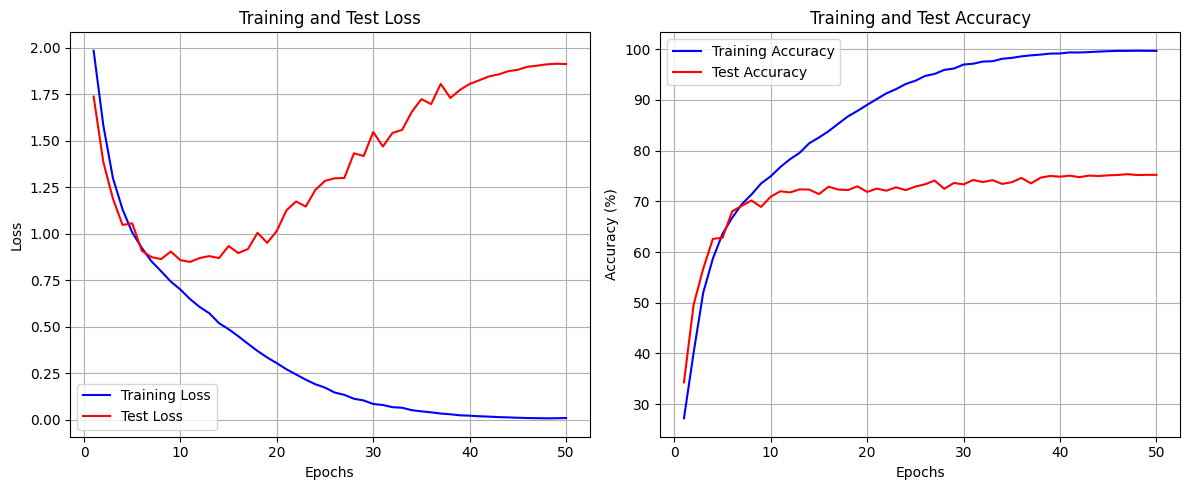


=== Running experiment: hyperparams_5 ===
Configuration:
  d_model: 384
  n_classes: 10
  img_size: (32, 32)
  patch_size: (4, 4)
  n_channels: 3
  n_heads: 12
  n_layers: 8
  mlp_ratio: 4
  dropout: 0.1
  batch_size: 128
  epochs: 50
  lr: 0.0003
  weight_decay: 0.05
  warmup_steps: 500
  pos_embedding_type: 1d_learned

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000, Test samples: 10000
Model parameters: 14.25M


Epoch 1/50 | Train Loss: 1.9806 | Train Acc: 26.77% | Test Loss: 1.7047 | Test Acc: 34.49%
Saving Best Model at Epoch 1 with Accuracy: 34.49%


Epoch 2/50 | Train Loss: 1.5875 | Train Acc: 40.35% | Test Loss: 1.4099 | Test Acc: 47.94%
Saving Best Model at Epoch 2 with Accuracy: 47.94%


Epoch 3/50 | Train Loss: 1.3270 | Train Acc: 51.13% | Test Loss: 1.2208 | Test Acc: 54.20%
Saving Best Model at Epoch 3 with Accuracy: 54.20%


Epoch 4/50 | Train Loss: 1.1520 | Train Acc: 57.83% | Test Loss: 1.1237 | Test Acc: 59.23%
Saving Best Model at Epoch 4 with Accuracy: 59.23%


Epoch 5/50 | Train Loss: 1.0136 | Train Acc: 63.20% | Test Loss: 1.0163 | Test Acc: 63.44%
Saving Best Model at Epoch 5 with Accuracy: 63.44%


Epoch 6/50 | Train Loss: 0.9223 | Train Acc: 66.89% | Test Loss: 1.0392 | Test Acc: 63.38%


Epoch 7/50 | Train Loss: 0.8447 | Train Acc: 69.72% | Test Loss: 0.9235 | Test Acc: 67.55%
Saving Best Model at Epoch 7 with Accuracy: 67.55%


Epoch 8/50 | Train Loss: 0.7855 | Train Acc: 71.88% | Test Loss: 0.9180 | Test Acc: 68.43%
Saving Best Model at Epoch 8 with Accuracy: 68.43%


Epoch 9/50 | Train Loss: 0.7281 | Train Acc: 74.15% | Test Loss: 0.9403 | Test Acc: 68.04%


Epoch 10/50 | Train Loss: 0.6906 | Train Acc: 75.38% | Test Loss: 0.9654 | Test Acc: 68.07%


Epoch 11/50 | Train Loss: 0.6384 | Train Acc: 77.08% | Test Loss: 0.8745 | Test Acc: 70.38%
Saving Best Model at Epoch 11 with Accuracy: 70.38%


Epoch 12/50 | Train Loss: 0.6020 | Train Acc: 78.41% | Test Loss: 0.8717 | Test Acc: 71.75%
Saving Best Model at Epoch 12 with Accuracy: 71.75%


Epoch 13/50 | Train Loss: 0.5523 | Train Acc: 80.23% | Test Loss: 0.8688 | Test Acc: 72.94%
Saving Best Model at Epoch 13 with Accuracy: 72.94%


Epoch 14/50 | Train Loss: 0.5138 | Train Acc: 81.60% | Test Loss: 0.9228 | Test Acc: 73.24%
Saving Best Model at Epoch 14 with Accuracy: 73.24%


Epoch 15/50 | Train Loss: 0.4762 | Train Acc: 82.88% | Test Loss: 0.8950 | Test Acc: 72.40%


Epoch 16/50 | Train Loss: 0.4368 | Train Acc: 84.33% | Test Loss: 1.0183 | Test Acc: 70.91%


Epoch 17/50 | Train Loss: 0.4094 | Train Acc: 85.22% | Test Loss: 0.9805 | Test Acc: 72.65%


Epoch 18/50 | Train Loss: 0.3712 | Train Acc: 86.63% | Test Loss: 1.0129 | Test Acc: 72.74%


Epoch 19/50 | Train Loss: 0.3317 | Train Acc: 88.19% | Test Loss: 1.0862 | Test Acc: 71.69%


Epoch 20/50 | Train Loss: 0.3051 | Train Acc: 89.06% | Test Loss: 1.1132 | Test Acc: 71.80%


Epoch 21/50 | Train Loss: 0.2807 | Train Acc: 89.82% | Test Loss: 1.0268 | Test Acc: 73.60%
Saving Best Model at Epoch 21 with Accuracy: 73.60%


Epoch 22/50 | Train Loss: 0.2509 | Train Acc: 90.90% | Test Loss: 1.1333 | Test Acc: 72.17%


Epoch 23/50 | Train Loss: 0.2272 | Train Acc: 91.73% | Test Loss: 1.2277 | Test Acc: 71.27%


KeyboardInterrupt: 

In [7]:
hyperparameter_results = hyperparameter_experiment()


=== Running experiment: no_augmentation ===
Configuration:
  d_model: 384
  n_classes: 10
  img_size: (32, 32)
  patch_size: (4, 4)
  n_channels: 3
  n_heads: 6
  n_layers: 8
  mlp_ratio: 4
  dropout: 0.1
  batch_size: 128
  epochs: 50
  lr: 0.0003
  weight_decay: 0.05
  warmup_steps: 500
  pos_embedding_type: 1d_learned

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000, Test samples: 10000
Model parameters: 14.25M


Epoch 1/50 | Train Loss: 1.9679 | Train Acc: 27.30% | Test Loss: 1.6989 | Test Acc: 35.25%
Saving Best Model at Epoch 1 with Accuracy: 35.25%


Epoch 2/50 | Train Loss: 1.5540 | Train Acc: 41.50% | Test Loss: 1.4775 | Test Acc: 44.90%
Saving Best Model at Epoch 2 with Accuracy: 44.90%


Epoch 3/50 | Train Loss: 1.2890 | Train Acc: 52.60% | Test Loss: 1.1724 | Test Acc: 57.61%
Saving Best Model at Epoch 3 with Accuracy: 57.61%


Epoch 4/50 | Train Loss: 1.0999 | Train Acc: 60.09% | Test Loss: 1.0404 | Test Acc: 62.74%
Saving Best Model at Epoch 4 with Accuracy: 62.74%


Epoch 5/50 | Train Loss: 0.9874 | Train Acc: 64.49% | Test Loss: 1.0088 | Test Acc: 65.17%
Saving Best Model at Epoch 5 with Accuracy: 65.17%


Epoch 6/50 | Train Loss: 0.9033 | Train Acc: 67.39% | Test Loss: 0.9895 | Test Acc: 65.73%
Saving Best Model at Epoch 6 with Accuracy: 65.73%


Epoch 7/50 | Train Loss: 0.8421 | Train Acc: 69.81% | Test Loss: 0.9651 | Test Acc: 67.08%
Saving Best Model at Epoch 7 with Accuracy: 67.08%


Epoch 8/50 | Train Loss: 0.7830 | Train Acc: 71.88% | Test Loss: 0.9252 | Test Acc: 67.71%
Saving Best Model at Epoch 8 with Accuracy: 67.71%


Epoch 9/50 | Train Loss: 0.7401 | Train Acc: 73.59% | Test Loss: 0.8823 | Test Acc: 70.09%
Saving Best Model at Epoch 9 with Accuracy: 70.09%


Epoch 10/50 | Train Loss: 0.6830 | Train Acc: 75.48% | Test Loss: 0.9362 | Test Acc: 67.83%


Epoch 11/50 | Train Loss: 0.6397 | Train Acc: 77.03% | Test Loss: 0.8445 | Test Acc: 71.72%
Saving Best Model at Epoch 11 with Accuracy: 71.72%


Epoch 12/50 | Train Loss: 0.6046 | Train Acc: 78.31% | Test Loss: 1.0105 | Test Acc: 69.02%


Epoch 13/50 | Train Loss: 0.5692 | Train Acc: 79.69% | Test Loss: 0.9153 | Test Acc: 71.09%


Epoch 14/50 | Train Loss: 0.5362 | Train Acc: 80.78% | Test Loss: 0.9726 | Test Acc: 70.25%


Epoch 15/50 | Train Loss: 0.4933 | Train Acc: 82.11% | Test Loss: 0.9517 | Test Acc: 71.78%
Saving Best Model at Epoch 15 with Accuracy: 71.78%


Epoch 16/50 | Train Loss: 0.4562 | Train Acc: 83.60% | Test Loss: 0.9160 | Test Acc: 72.62%
Saving Best Model at Epoch 16 with Accuracy: 72.62%


Epoch 17/50 | Train Loss: 0.4228 | Train Acc: 84.74% | Test Loss: 0.9337 | Test Acc: 72.43%


Epoch 18/50 | Train Loss: 0.3907 | Train Acc: 85.91% | Test Loss: 1.0703 | Test Acc: 70.73%


Epoch 19/50 | Train Loss: 0.3499 | Train Acc: 87.40% | Test Loss: 0.9967 | Test Acc: 73.27%
Saving Best Model at Epoch 19 with Accuracy: 73.27%


Epoch 20/50 | Train Loss: 0.3237 | Train Acc: 88.35% | Test Loss: 1.0402 | Test Acc: 72.47%


Epoch 21/50 | Train Loss: 0.2911 | Train Acc: 89.39% | Test Loss: 1.0955 | Test Acc: 71.85%


Epoch 22/50 | Train Loss: 0.2669 | Train Acc: 90.32% | Test Loss: 1.0984 | Test Acc: 73.04%


Epoch 23/50 | Train Loss: 0.2425 | Train Acc: 91.14% | Test Loss: 1.1358 | Test Acc: 72.82%


Epoch 24/50 | Train Loss: 0.2143 | Train Acc: 92.18% | Test Loss: 1.2839 | Test Acc: 71.37%


Epoch 25/50 | Train Loss: 0.2014 | Train Acc: 92.70% | Test Loss: 1.1718 | Test Acc: 73.56%
Saving Best Model at Epoch 25 with Accuracy: 73.56%


Epoch 26/50 | Train Loss: 0.1710 | Train Acc: 93.69% | Test Loss: 1.3882 | Test Acc: 71.72%


Epoch 27/50 | Train Loss: 0.1540 | Train Acc: 94.40% | Test Loss: 1.3122 | Test Acc: 73.54%


Epoch 28/50 | Train Loss: 0.1326 | Train Acc: 95.14% | Test Loss: 1.4257 | Test Acc: 72.26%


Epoch 29/50 | Train Loss: 0.1197 | Train Acc: 95.61% | Test Loss: 1.4166 | Test Acc: 73.65%
Saving Best Model at Epoch 29 with Accuracy: 73.65%


Epoch 30/50 | Train Loss: 0.1054 | Train Acc: 96.26% | Test Loss: 1.5435 | Test Acc: 72.08%


Epoch 31/50 | Train Loss: 0.0958 | Train Acc: 96.47% | Test Loss: 1.4594 | Test Acc: 73.72%
Saving Best Model at Epoch 31 with Accuracy: 73.72%


Epoch 32/50 | Train Loss: 0.0794 | Train Acc: 97.10% | Test Loss: 1.5230 | Test Acc: 73.64%


Epoch 33/50 | Train Loss: 0.0702 | Train Acc: 97.46% | Test Loss: 1.6151 | Test Acc: 72.96%


Epoch 34/50 | Train Loss: 0.0618 | Train Acc: 97.78% | Test Loss: 1.5816 | Test Acc: 74.38%
Saving Best Model at Epoch 34 with Accuracy: 74.38%


Epoch 35/50 | Train Loss: 0.0574 | Train Acc: 97.87% | Test Loss: 1.6828 | Test Acc: 73.03%


Epoch 36/50 | Train Loss: 0.0486 | Train Acc: 98.27% | Test Loss: 1.6747 | Test Acc: 73.48%


Epoch 37/50 | Train Loss: 0.0416 | Train Acc: 98.47% | Test Loss: 1.7512 | Test Acc: 73.16%


Epoch 38/50 | Train Loss: 0.0379 | Train Acc: 98.62% | Test Loss: 1.7201 | Test Acc: 74.22%


Epoch 39/50 | Train Loss: 0.0312 | Train Acc: 98.87% | Test Loss: 1.7544 | Test Acc: 74.52%
Saving Best Model at Epoch 39 with Accuracy: 74.52%


Epoch 40/50 | Train Loss: 0.0290 | Train Acc: 98.98% | Test Loss: 1.7877 | Test Acc: 74.67%
Saving Best Model at Epoch 40 with Accuracy: 74.67%


Epoch 41/50 | Train Loss: 0.0245 | Train Acc: 99.20% | Test Loss: 1.8072 | Test Acc: 74.21%


Epoch 42/50 | Train Loss: 0.0213 | Train Acc: 99.27% | Test Loss: 1.8187 | Test Acc: 74.18%


Epoch 43/50 | Train Loss: 0.0186 | Train Acc: 99.39% | Test Loss: 1.8355 | Test Acc: 74.60%


Epoch 44/50 | Train Loss: 0.0167 | Train Acc: 99.46% | Test Loss: 1.8214 | Test Acc: 75.08%
Saving Best Model at Epoch 44 with Accuracy: 75.08%


Epoch 45/50 | Train Loss: 0.0154 | Train Acc: 99.46% | Test Loss: 1.8448 | Test Acc: 74.93%


Epoch 46/50 | Train Loss: 0.0131 | Train Acc: 99.57% | Test Loss: 1.8598 | Test Acc: 75.00%


Epoch 47/50 | Train Loss: 0.0126 | Train Acc: 99.58% | Test Loss: 1.8580 | Test Acc: 74.81%


Epoch 48/50 | Train Loss: 0.0116 | Train Acc: 99.61% | Test Loss: 1.8620 | Test Acc: 74.86%


Epoch 49/50 | Train Loss: 0.0117 | Train Acc: 99.65% | Test Loss: 1.8624 | Test Acc: 74.91%


Epoch 50/50 | Train Loss: 0.0116 | Train Acc: 99.61% | Test Loss: 1.8635 | Test Acc: 74.89%

Best Test Accuracy: 75.08% — Model saved to: best_vit_model.pth


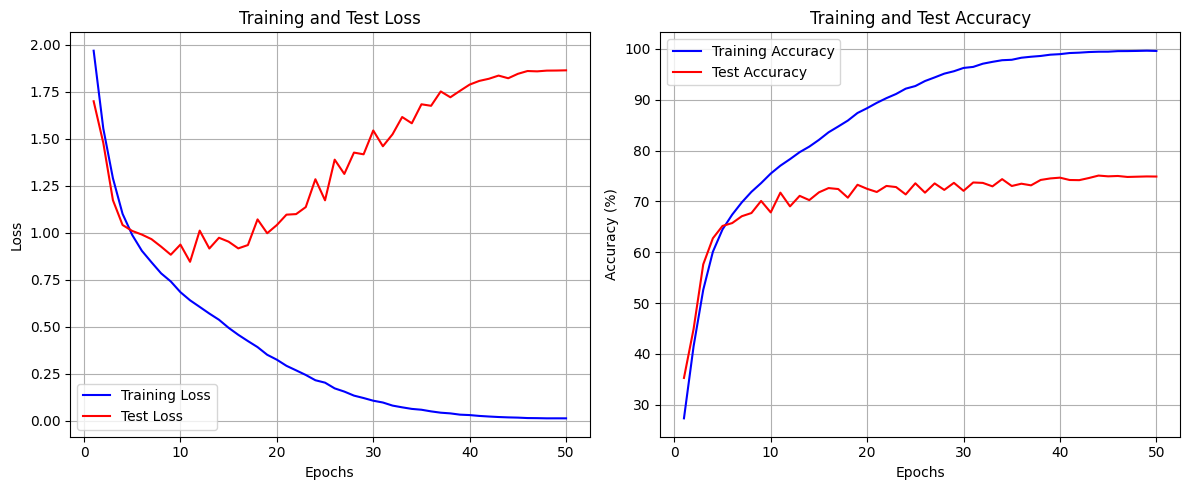


=== Running experiment: basic_augmentation ===
Configuration:
  d_model: 384
  n_classes: 10
  img_size: (32, 32)
  patch_size: (4, 4)
  n_channels: 3
  n_heads: 6
  n_layers: 8
  mlp_ratio: 4
  dropout: 0.1
  batch_size: 128
  epochs: 50
  lr: 0.0003
  weight_decay: 0.05
  warmup_steps: 500
  pos_embedding_type: 1d_learned

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000, Test samples: 10000
Model parameters: 14.25M


Epoch 1/50 | Train Loss: 2.0278 | Train Acc: 25.00% | Test Loss: 1.7474 | Test Acc: 34.08%
Saving Best Model at Epoch 1 with Accuracy: 34.08%


Epoch 2/50 | Train Loss: 1.6930 | Train Acc: 35.42% | Test Loss: 1.5131 | Test Acc: 44.48%
Saving Best Model at Epoch 2 with Accuracy: 44.48%


Epoch 3/50 | Train Loss: 1.4383 | Train Acc: 47.03% | Test Loss: 1.3621 | Test Acc: 51.93%
Saving Best Model at Epoch 3 with Accuracy: 51.93%


Epoch 4/50 | Train Loss: 1.2599 | Train Acc: 54.15% | Test Loss: 1.2726 | Test Acc: 55.18%
Saving Best Model at Epoch 4 with Accuracy: 55.18%


Epoch 5/50 | Train Loss: 1.1530 | Train Acc: 58.13% | Test Loss: 1.1188 | Test Acc: 61.17%
Saving Best Model at Epoch 5 with Accuracy: 61.17%


Epoch 6/50 | Train Loss: 1.0767 | Train Acc: 61.08% | Test Loss: 1.0868 | Test Acc: 62.74%
Saving Best Model at Epoch 6 with Accuracy: 62.74%


Epoch 7/50 | Train Loss: 1.0301 | Train Acc: 63.07% | Test Loss: 1.1082 | Test Acc: 62.38%


Epoch 8/50 | Train Loss: 0.9766 | Train Acc: 65.13% | Test Loss: 1.0108 | Test Acc: 65.43%
Saving Best Model at Epoch 8 with Accuracy: 65.43%


Epoch 9/50 | Train Loss: 0.9415 | Train Acc: 66.27% | Test Loss: 1.0392 | Test Acc: 65.97%
Saving Best Model at Epoch 9 with Accuracy: 65.97%


Epoch 10/50 | Train Loss: 0.9127 | Train Acc: 67.44% | Test Loss: 0.9787 | Test Acc: 67.31%
Saving Best Model at Epoch 10 with Accuracy: 67.31%


Epoch 11/50 | Train Loss: 0.8750 | Train Acc: 68.76% | Test Loss: 0.9719 | Test Acc: 68.02%
Saving Best Model at Epoch 11 with Accuracy: 68.02%


Epoch 12/50 | Train Loss: 0.8467 | Train Acc: 69.79% | Test Loss: 0.9165 | Test Acc: 69.00%
Saving Best Model at Epoch 12 with Accuracy: 69.00%


Epoch 13/50 | Train Loss: 0.8181 | Train Acc: 70.82% | Test Loss: 0.9679 | Test Acc: 69.26%
Saving Best Model at Epoch 13 with Accuracy: 69.26%


Epoch 14/50 | Train Loss: 0.8000 | Train Acc: 71.32% | Test Loss: 0.9655 | Test Acc: 68.59%


Epoch 15/50 | Train Loss: 0.7812 | Train Acc: 72.19% | Test Loss: 0.8737 | Test Acc: 70.96%
Saving Best Model at Epoch 15 with Accuracy: 70.96%


Epoch 16/50 | Train Loss: 0.7525 | Train Acc: 73.30% | Test Loss: 0.8389 | Test Acc: 72.66%
Saving Best Model at Epoch 16 with Accuracy: 72.66%


Epoch 17/50 | Train Loss: 0.7309 | Train Acc: 74.15% | Test Loss: 0.8691 | Test Acc: 72.19%


Epoch 18/50 | Train Loss: 0.7047 | Train Acc: 74.91% | Test Loss: 0.8740 | Test Acc: 71.67%


Epoch 19/50 | Train Loss: 0.6839 | Train Acc: 75.65% | Test Loss: 0.8099 | Test Acc: 72.91%
Saving Best Model at Epoch 19 with Accuracy: 72.91%


Epoch 20/50 | Train Loss: 0.6695 | Train Acc: 76.12% | Test Loss: 0.8029 | Test Acc: 73.66%
Saving Best Model at Epoch 20 with Accuracy: 73.66%


Epoch 21/50 | Train Loss: 0.6489 | Train Acc: 76.86% | Test Loss: 0.7792 | Test Acc: 74.86%
Saving Best Model at Epoch 21 with Accuracy: 74.86%


Epoch 22/50 | Train Loss: 0.6348 | Train Acc: 77.45% | Test Loss: 0.7891 | Test Acc: 74.49%


Epoch 23/50 | Train Loss: 0.6202 | Train Acc: 78.11% | Test Loss: 0.8566 | Test Acc: 73.42%


Epoch 24/50 | Train Loss: 0.5911 | Train Acc: 79.06% | Test Loss: 0.7868 | Test Acc: 74.77%


Epoch 25/50 | Train Loss: 0.5756 | Train Acc: 79.51% | Test Loss: 0.7424 | Test Acc: 76.27%
Saving Best Model at Epoch 25 with Accuracy: 76.27%


Epoch 26/50 | Train Loss: 0.5622 | Train Acc: 79.94% | Test Loss: 0.7394 | Test Acc: 76.75%
Saving Best Model at Epoch 26 with Accuracy: 76.75%


Epoch 27/50 | Train Loss: 0.5423 | Train Acc: 80.60% | Test Loss: 0.7330 | Test Acc: 76.46%


Epoch 28/50 | Train Loss: 0.5305 | Train Acc: 80.90% | Test Loss: 0.7716 | Test Acc: 75.66%


Epoch 29/50 | Train Loss: 0.5170 | Train Acc: 81.65% | Test Loss: 0.7321 | Test Acc: 76.63%


Epoch 30/50 | Train Loss: 0.4975 | Train Acc: 82.32% | Test Loss: 0.7286 | Test Acc: 77.57%
Saving Best Model at Epoch 30 with Accuracy: 77.57%


Epoch 31/50 | Train Loss: 0.4859 | Train Acc: 82.65% | Test Loss: 0.7249 | Test Acc: 77.83%
Saving Best Model at Epoch 31 with Accuracy: 77.83%


Epoch 32/50 | Train Loss: 0.4696 | Train Acc: 83.37% | Test Loss: 0.7060 | Test Acc: 78.34%
Saving Best Model at Epoch 32 with Accuracy: 78.34%


Epoch 33/50 | Train Loss: 0.4550 | Train Acc: 83.74% | Test Loss: 0.6957 | Test Acc: 78.01%


Epoch 34/50 | Train Loss: 0.4453 | Train Acc: 83.98% | Test Loss: 0.6966 | Test Acc: 78.55%
Saving Best Model at Epoch 34 with Accuracy: 78.55%


Epoch 35/50 | Train Loss: 0.4291 | Train Acc: 84.62% | Test Loss: 0.7572 | Test Acc: 77.95%


Epoch 36/50 | Train Loss: 0.4239 | Train Acc: 84.87% | Test Loss: 0.6852 | Test Acc: 79.03%
Saving Best Model at Epoch 36 with Accuracy: 79.03%


Epoch 37/50 | Train Loss: 0.4064 | Train Acc: 85.51% | Test Loss: 0.7315 | Test Acc: 78.66%


Epoch 38/50 | Train Loss: 0.4021 | Train Acc: 85.55% | Test Loss: 0.6991 | Test Acc: 78.77%


Epoch 39/50 | Train Loss: 0.3901 | Train Acc: 86.11% | Test Loss: 0.7219 | Test Acc: 78.81%


Epoch 40/50 | Train Loss: 0.3796 | Train Acc: 86.33% | Test Loss: 0.6827 | Test Acc: 79.70%
Saving Best Model at Epoch 40 with Accuracy: 79.70%


Epoch 41/50 | Train Loss: 0.3719 | Train Acc: 86.69% | Test Loss: 0.7163 | Test Acc: 79.06%


Epoch 42/50 | Train Loss: 0.3639 | Train Acc: 86.86% | Test Loss: 0.7233 | Test Acc: 79.64%


Epoch 43/50 | Train Loss: 0.3573 | Train Acc: 87.07% | Test Loss: 0.7149 | Test Acc: 79.65%


Epoch 44/50 | Train Loss: 0.3514 | Train Acc: 87.25% | Test Loss: 0.7232 | Test Acc: 79.44%


Epoch 45/50 | Train Loss: 0.3492 | Train Acc: 87.37% | Test Loss: 0.7213 | Test Acc: 79.39%


Epoch 46/50 | Train Loss: 0.3421 | Train Acc: 87.61% | Test Loss: 0.7204 | Test Acc: 79.54%


Epoch 47/50 | Train Loss: 0.3430 | Train Acc: 87.49% | Test Loss: 0.7143 | Test Acc: 79.59%


Epoch 48/50 | Train Loss: 0.3367 | Train Acc: 87.90% | Test Loss: 0.7244 | Test Acc: 79.43%


Epoch 49/50 | Train Loss: 0.3419 | Train Acc: 87.62% | Test Loss: 0.7211 | Test Acc: 79.46%


Epoch 50/50 | Train Loss: 0.3343 | Train Acc: 87.93% | Test Loss: 0.7212 | Test Acc: 79.44%

Best Test Accuracy: 79.70% — Model saved to: best_vit_model.pth


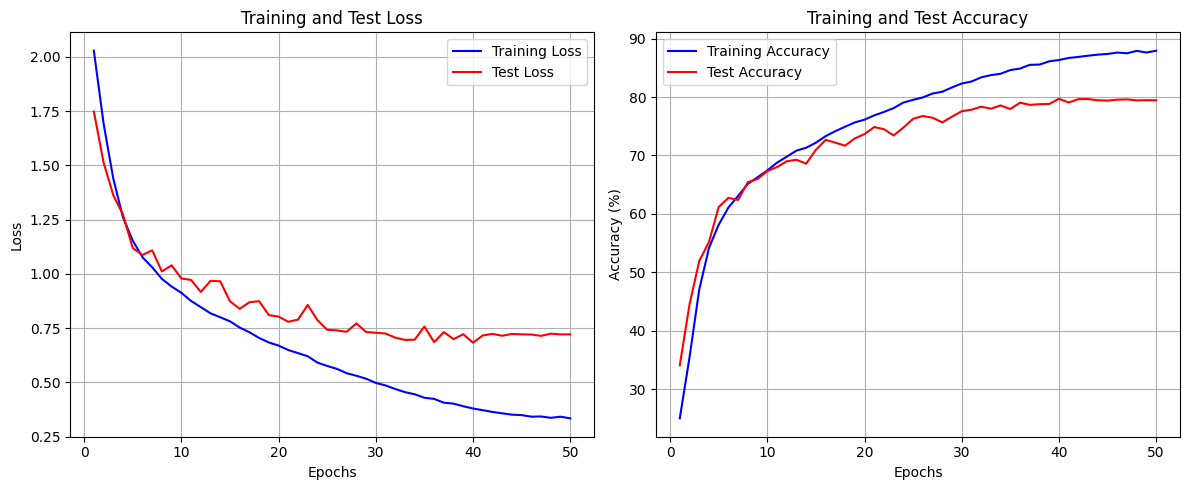


=== Running experiment: advanced_augmentation ===
Configuration:
  d_model: 384
  n_classes: 10
  img_size: (32, 32)
  patch_size: (4, 4)
  n_channels: 3
  n_heads: 6
  n_layers: 8
  mlp_ratio: 4
  dropout: 0.1
  batch_size: 128
  epochs: 50
  lr: 0.0003
  weight_decay: 0.05
  warmup_steps: 500
  pos_embedding_type: 1d_learned

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000, Test samples: 10000
Model parameters: 14.25M


Epoch 1/50 | Train Loss: 2.0023 | Train Acc: 26.00% | Test Loss: 1.7393 | Test Acc: 34.13%
Saving Best Model at Epoch 1 with Accuracy: 34.13%


Epoch 2/50 | Train Loss: 1.6531 | Train Acc: 38.21% | Test Loss: 1.6586 | Test Acc: 40.69%
Saving Best Model at Epoch 2 with Accuracy: 40.69%


Epoch 3/50 | Train Loss: 1.4010 | Train Acc: 48.42% | Test Loss: 1.2832 | Test Acc: 53.98%
Saving Best Model at Epoch 3 with Accuracy: 53.98%


Epoch 4/50 | Train Loss: 1.2246 | Train Acc: 55.39% | Test Loss: 1.2019 | Test Acc: 56.08%
Saving Best Model at Epoch 4 with Accuracy: 56.08%


Epoch 5/50 | Train Loss: 1.1149 | Train Acc: 59.79% | Test Loss: 1.0180 | Test Acc: 64.10%
Saving Best Model at Epoch 5 with Accuracy: 64.10%


Epoch 6/50 | Train Loss: 1.0350 | Train Acc: 62.54% | Test Loss: 0.9641 | Test Acc: 66.39%
Saving Best Model at Epoch 6 with Accuracy: 66.39%


Epoch 7/50 | Train Loss: 0.9700 | Train Acc: 65.29% | Test Loss: 0.9737 | Test Acc: 66.80%
Saving Best Model at Epoch 7 with Accuracy: 66.80%


Epoch 8/50 | Train Loss: 0.9188 | Train Acc: 67.34% | Test Loss: 0.9559 | Test Acc: 66.84%
Saving Best Model at Epoch 8 with Accuracy: 66.84%


Epoch 9/50 | Train Loss: 0.8894 | Train Acc: 68.29% | Test Loss: 1.0719 | Test Acc: 64.98%


Epoch 10/50 | Train Loss: 0.8510 | Train Acc: 69.86% | Test Loss: 0.9762 | Test Acc: 66.81%


Epoch 11/50 | Train Loss: 0.8201 | Train Acc: 70.86% | Test Loss: 0.8887 | Test Acc: 69.86%
Saving Best Model at Epoch 11 with Accuracy: 69.86%


Epoch 12/50 | Train Loss: 0.7950 | Train Acc: 71.88% | Test Loss: 0.7778 | Test Acc: 72.58%
Saving Best Model at Epoch 12 with Accuracy: 72.58%


Epoch 13/50 | Train Loss: 0.7760 | Train Acc: 72.46% | Test Loss: 0.8703 | Test Acc: 71.04%


Epoch 14/50 | Train Loss: 0.7452 | Train Acc: 73.59% | Test Loss: 0.8181 | Test Acc: 73.06%
Saving Best Model at Epoch 14 with Accuracy: 73.06%


Epoch 15/50 | Train Loss: 0.7273 | Train Acc: 74.38% | Test Loss: 0.8938 | Test Acc: 70.91%


Epoch 16/50 | Train Loss: 0.7068 | Train Acc: 74.85% | Test Loss: 0.8522 | Test Acc: 71.00%


Epoch 17/50 | Train Loss: 0.6828 | Train Acc: 75.96% | Test Loss: 0.8168 | Test Acc: 72.79%


Epoch 18/50 | Train Loss: 0.6652 | Train Acc: 76.36% | Test Loss: 0.7833 | Test Acc: 74.16%
Saving Best Model at Epoch 18 with Accuracy: 74.16%


Epoch 19/50 | Train Loss: 0.6486 | Train Acc: 77.13% | Test Loss: 0.8280 | Test Acc: 72.76%


Epoch 20/50 | Train Loss: 0.6243 | Train Acc: 77.77% | Test Loss: 0.7869 | Test Acc: 73.98%


Epoch 21/50 | Train Loss: 0.6060 | Train Acc: 78.48% | Test Loss: 0.7035 | Test Acc: 76.10%
Saving Best Model at Epoch 21 with Accuracy: 76.10%


Epoch 22/50 | Train Loss: 0.5885 | Train Acc: 79.13% | Test Loss: 0.7888 | Test Acc: 74.59%


Epoch 23/50 | Train Loss: 0.5705 | Train Acc: 79.81% | Test Loss: 0.8067 | Test Acc: 73.81%


Epoch 24/50 | Train Loss: 0.5576 | Train Acc: 80.35% | Test Loss: 0.7240 | Test Acc: 75.17%


Epoch 25/50 | Train Loss: 0.5391 | Train Acc: 80.70% | Test Loss: 0.7062 | Test Acc: 76.61%
Saving Best Model at Epoch 25 with Accuracy: 76.61%


Epoch 26/50 | Train Loss: 0.5264 | Train Acc: 81.25% | Test Loss: 0.7325 | Test Acc: 76.25%


Epoch 27/50 | Train Loss: 0.5102 | Train Acc: 81.97% | Test Loss: 0.7458 | Test Acc: 76.49%


Epoch 28/50 | Train Loss: 0.4940 | Train Acc: 82.32% | Test Loss: 0.7102 | Test Acc: 76.72%
Saving Best Model at Epoch 28 with Accuracy: 76.72%


Epoch 29/50 | Train Loss: 0.4812 | Train Acc: 82.91% | Test Loss: 0.7548 | Test Acc: 76.10%


Epoch 30/50 | Train Loss: 0.4627 | Train Acc: 83.39% | Test Loss: 0.7030 | Test Acc: 77.38%
Saving Best Model at Epoch 30 with Accuracy: 77.38%


Epoch 31/50 | Train Loss: 0.4521 | Train Acc: 83.80% | Test Loss: 0.7050 | Test Acc: 77.82%
Saving Best Model at Epoch 31 with Accuracy: 77.82%


Epoch 32/50 | Train Loss: 0.4295 | Train Acc: 84.83% | Test Loss: 0.7346 | Test Acc: 77.37%


Epoch 33/50 | Train Loss: 0.4211 | Train Acc: 84.86% | Test Loss: 0.7351 | Test Acc: 77.54%


Epoch 34/50 | Train Loss: 0.4121 | Train Acc: 85.33% | Test Loss: 0.7251 | Test Acc: 77.90%
Saving Best Model at Epoch 34 with Accuracy: 77.90%


Epoch 35/50 | Train Loss: 0.3952 | Train Acc: 85.89% | Test Loss: 0.7018 | Test Acc: 78.70%
Saving Best Model at Epoch 35 with Accuracy: 78.70%


Epoch 36/50 | Train Loss: 0.3825 | Train Acc: 86.20% | Test Loss: 0.7059 | Test Acc: 78.46%


Epoch 37/50 | Train Loss: 0.3707 | Train Acc: 86.93% | Test Loss: 0.7354 | Test Acc: 78.02%


Epoch 38/50 | Train Loss: 0.3682 | Train Acc: 86.68% | Test Loss: 0.7093 | Test Acc: 78.48%


Epoch 39/50 | Train Loss: 0.3533 | Train Acc: 87.44% | Test Loss: 0.6853 | Test Acc: 79.13%
Saving Best Model at Epoch 39 with Accuracy: 79.13%


Epoch 40/50 | Train Loss: 0.3404 | Train Acc: 87.74% | Test Loss: 0.7583 | Test Acc: 77.98%


Epoch 41/50 | Train Loss: 0.3316 | Train Acc: 88.25% | Test Loss: 0.7136 | Test Acc: 79.19%
Saving Best Model at Epoch 41 with Accuracy: 79.19%


Epoch 42/50 | Train Loss: 0.3276 | Train Acc: 88.05% | Test Loss: 0.7001 | Test Acc: 79.40%
Saving Best Model at Epoch 42 with Accuracy: 79.40%


Epoch 43/50 | Train Loss: 0.3221 | Train Acc: 88.46% | Test Loss: 0.7112 | Test Acc: 79.36%


Epoch 44/50 | Train Loss: 0.3181 | Train Acc: 88.48% | Test Loss: 0.7071 | Test Acc: 79.60%
Saving Best Model at Epoch 44 with Accuracy: 79.60%


Epoch 45/50 | Train Loss: 0.3094 | Train Acc: 88.92% | Test Loss: 0.7168 | Test Acc: 79.52%


Epoch 46/50 | Train Loss: 0.3055 | Train Acc: 88.92% | Test Loss: 0.7136 | Test Acc: 79.53%


Epoch 47/50 | Train Loss: 0.3017 | Train Acc: 89.07% | Test Loss: 0.7226 | Test Acc: 79.28%


Epoch 48/50 | Train Loss: 0.3033 | Train Acc: 89.12% | Test Loss: 0.7130 | Test Acc: 79.44%


Epoch 49/50 | Train Loss: 0.3043 | Train Acc: 89.12% | Test Loss: 0.7134 | Test Acc: 79.49%


Epoch 50/50 | Train Loss: 0.2990 | Train Acc: 89.29% | Test Loss: 0.7130 | Test Acc: 79.50%

Best Test Accuracy: 79.60% — Model saved to: best_vit_model.pth


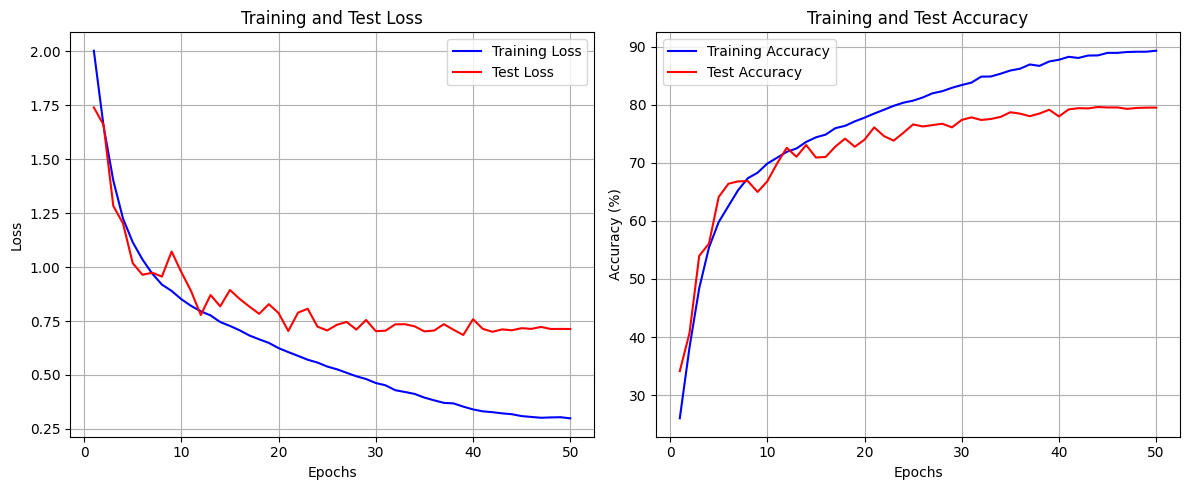


=== Running experiment: randaugment ===
Configuration:
  d_model: 384
  n_classes: 10
  img_size: (32, 32)
  patch_size: (4, 4)
  n_channels: 3
  n_heads: 6
  n_layers: 8
  mlp_ratio: 4
  dropout: 0.1
  batch_size: 128
  epochs: 50
  lr: 0.0003
  weight_decay: 0.05
  warmup_steps: 500
  pos_embedding_type: 1d_learned

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000, Test samples: 10000
Model parameters: 14.25M


Training:  97%|█████████▋| 378/391 [02:08<00:04,  2.95it/s, loss=2.13, acc=21.6]

In [ ]:
augmentation_results = augmentation_experiment()